# Анализ и прогнозирование трендов на рынке цифровых товаров
__[Александр Бинько](https://t.me/ABin_98)__

# ➢ Описание проекта  
_Интернет-магазин цифровых товаров формирует бюджет рекламных компаний,  
необходимо предложить заказчику data-driven подход к определению потенциально  
популярных продуктов._

# ➢ Требования  
> * Провести **EDA** для датасета, полученного от интернет-магазина
>
>
> * Отфильтровать данные, устранить найденные ошибки
>
>
> * Провести комплекс статистических тестов
>
>
> * Интерпретировать полученные результаты, составить список рекомендаций
> для заказчика


# ➢ Полученные данные  
_Для выполнения проекта был получен один файл с расширением_ **.csv**, \
    _объёмом 1,4 МБ. Файл содержит необходимые для исследования данные, \
    разделенные на 11 столбцов._


### **Стек проекта:**  
**python** 3.12 | **pandas** 2.2.2  
**seaborn** 0.13.2 | **numpy**  1.26.4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.cm as cm

from scipy import stats as st

warnings.filterwarnings("ignore")

# Ⅰ Шаг. Загрузка данных и изучение общей информации

In [2]:
df = pd.read_csv('games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


**Промежуточный вывод:**
>_Данные получены в полном объёме, в соответствии с техническим заданием.  
В дневник исследования потребуется внесение информации об объёмной доле пропусков  
в столбцах._

## ➢ Описание данных

**name** - _название игры, может совпадать для разных платформ и являться  
подстрокой в других названиях._

**platform** - _наименование платформы, для которой издавался тайтл,  
название может являться подстрокой._

**year_of_release** - _числовой признак, содержащий год выхода продукта на  
указанной платформе, один из важнейших компонентов анализа временных данных._

**genre** - _категориальный признак из ограниченного набора, содержит информацию  
о жанре тайтла, информация о поджанрах от заказчика не получена, хотя могла бы  
быть полезна на этапе интерпретации статистических тестов._

**NA/EU/JP/Other_sales** - _количественные данные об объёмах продаж продукта  
в различных регионах._

**critic_score** - _числовой показатель, содержит оценку тайтла  
игровыми критиками, является натуральным числом._

**user_score** - _числовой показатель, содержит усреднённую пользовательскую  
оценку, имеет дробную часть._

**rating** - _категориальный признак из ограниченного набора, выражен  
конвенциональной маркировкой, указывающий на возрастной ценз._

**total_sales** - _суммарное количество проданных копий._

## Вывод шага Ⅰ:  
> Удалось успешно сформировать и проинспектировать датафрейм, все колонки,  
указанные в техническом задании представлены в полном объёме. Названия признаков  
нуждаются в редактировании, некоторые типы данных можно модифицировать, чтобы  
оптимизировать затраты ресурсов.

# Ⅱ Шаг. Подготовка данных

## ➢ Унифицируем названия колонок

In [5]:
df.rename(columns=lambda x: x.lower(), inplace=True)

## ➢ Модифицируем типы данных  
_Перед приведением типов сделаем автоматическую проверку на предмет содержания  
в данных потенциально важной информации, которая может быть утеряна в процессе  
преобразования._ 

In [6]:
def check_fractional_values(df, columns):
    for column in columns:
        fractional_count = sum(df[column][df[column].notna()] % 1 != 0)
        if fractional_count == 0:
            print(
                f"Количество дробных значений в столбце '{column}': {fractional_count}\n"
                "> Можно выполнять приведение к целочисленному типу!\n")
        else:
            print(
                f"Количество дробных значений в столбце '{column}': {fractional_count}\n"
                "> Перед изменением типа нужны дополнительные проверки!\n")

In [7]:
check_fractional_values(df, ['year_of_release', 'critic_score'])

Количество дробных значений в столбце 'year_of_release': 0
> Можно выполнять приведение к целочисленному типу!

Количество дробных значений в столбце 'critic_score': 0
> Можно выполнять приведение к целочисленному типу!



In [8]:
for column in ['platform', 'genre', 'rating', 'name']:
    df[column] = df[column].astype('category')

df['user_score'].replace('tbd', np.nan, inplace=True)
df['rating'].fillna('RP', inplace=True)

for column in ['na_sales', 'eu_sales', 'jp_sales',
               'other_sales', 'critic_score', 'user_score',
               'year_of_release']:
    df[column] = df[column].astype('float32')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  category
 1   platform         16715 non-null  category
 2   year_of_release  16446 non-null  float32 
 3   genre            16713 non-null  category
 4   na_sales         16715 non-null  float32 
 5   eu_sales         16715 non-null  float32 
 6   jp_sales         16715 non-null  float32 
 7   other_sales      16715 non-null  float32 
 8   critic_score     8137 non-null   float32 
 9   user_score       7590 non-null   float32 
 10  rating           16715 non-null  category
dtypes: category(4), float32(7)
memory usage: 889.2 KB


**Промежуточный вывод:**
>_Оптимизация хранения позволила сэкономить 0.5MB памяти. Каст типов был  
предварительно проверен на безопасность. Столбец user_score содержал  
строку "tbd" - "to be determined", такие значения были приведены к стандартному
типу данных NaN._

## ➢ Обработка пропущенных значений

In [9]:
print("Число строк дубликатов:", df.duplicated().sum())

Число строк дубликатов: 0


In [10]:
duplicates = df.duplicated(subset=['name', 'platform', 'year_of_release'],
                           keep=False)
duplicate_rows = df[duplicates]
duplicate_rows

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,RP
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,RP
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [11]:
df.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first',
                   inplace=True)

**Промежуточный вывод:**
>_Полных дубликатов в наборе не обнаружено, что может свидетельствовать о высоком  
качестве организации процесса сбора данных заказчиком. Однако, исследование выявило  
несколько неявных дубликатов, удалим их, оставив первые вхождения.  
Повреждённую строку занесём в журнал исследования и обработаем на соответсвующем  
этапе._

In [12]:
pd.DataFrame({'missing_values': df.isna().sum(),
              'normalized_missing_values': df.isna().sum() / len(df)})

,missing_values,normalized_missing_values
name,1,0.000060
platform,0,0.000000
year_of_release,269,0.016095
genre,1,0.000060
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000
other_sales,0,0.000000
critic_score,8577,0.513193
user_score,9124,0.545922


In [13]:
df[df['name'].isna()]
df.dropna(subset=['name'], inplace=True)

**Промежуточный вывод:**
>_Столбец "name" содержит пропуск в одной записи, в процессе инспекции  
удалось определить, что строка является повреждённой, удалим ее из датафрейма,  
одновременно решив проблему с пропуском в колонке "genre". Год выпуска некоторых  
тайтлов не указан, допустимо мануальное заполнение на основании данных из  
открытых источников, однако количество пропущенных значений невелико, сделаем  
заметку в исследовательском дневнике и удалим строки. В случае неуверенности  
в результатах работы восстановим данные и заполним пропуски._

In [14]:
df.dropna(subset=['year_of_release'], inplace=True)

In [15]:
display(pd.DataFrame({'missing_values': df.isna().sum(),
                      'normalized_missing_values': df.isna().sum() / len(df)}))

,missing_values,normalized_missing_values
name,0,0.000000
platform,0,0.000000
year_of_release,0,0.000000
genre,0,0.000000
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000
other_sales,0,0.000000
critic_score,8461,0.514565
user_score,8981,0.546190


## ➢ Формирование столбца с суммарными продажами

In [16]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(
    axis=1)

## Вывод шага Ⅱ:  
> Пропуски в данных были успешно обработаны, основной стратегией заполнения  
было выбрано удаление. Значительная доля пустых полей в столбцах _critic_score_  
и _user_score_ образовалась в следствии отсутствия информации об оценках  
продукта критиками и/или пользователями, возможно издатель отказался от участия  
в программе ESRB. Заполнение медианным значением по названию внесёт значительное  
смещение в оценку, так как оценки тайтла могут сильно отличаться друг от друга  
в зависимости от выбранной платформы.

# Ⅲ Шаг. Исследовательский анализ

## ➢ Динамика насыщения рынка (1980 - 2016)

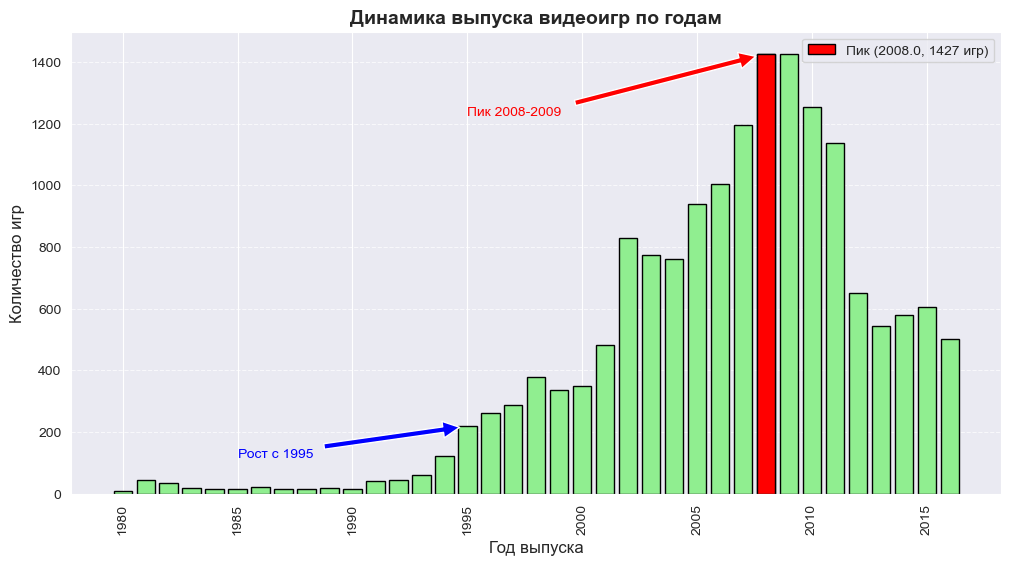

In [17]:
games_per_year = df.pivot_table(index='year_of_release', values='name',
                                aggfunc='count')

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(games_per_year.index, games_per_year['name'], color='lightgreen',
              edgecolor='black')

ax.grid(axis='y', linestyle='--', alpha=0.7)

max_year = games_per_year['name'].idxmax()
max_value = games_per_year['name'].max()
ax.bar(max_year, max_value, color='red', edgecolor='black',
       label=f'Пик ({max_year}, {max_value} игр)')

ax.annotate(f'Рост с 1995', xy=(1995, games_per_year.loc[1995]),
            xytext=(1985, games_per_year.loc[1995] - 100),
            arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=10,
            color='blue')

ax.annotate(f'Пик 2008-2009', xy=(max_year, max_value),
            xytext=(1995, max_value - 200),
            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10,
            color='red')

plt.title('Динамика выпуска видеоигр по годам', fontsize=14, fontweight='bold')
plt.xlabel('Год выпуска', fontsize=12)
plt.ylabel('Количество игр', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

plt.show()


**Промежуточный вывод:**
>_С 1995 года наблюдается устойчивая тенденция роста количества выпускаемых видеоигр, что свидетельствует о  
расширении рынка и увеличении конкурентной среды. Максимального уровня индустрия достигла в 2008–2009 годах,  
после чего последовал резкий спад выпуска тайтлов, вероятно, обусловленный рыночной консолидацией,  
изменениями в стратегиях издателей и смещением вектора развития индустрии. С точки зрения бизнес-анализа и  
рекламного планирования, актуальные данные должны отражать современные рыночные условия, включая изменения в  
потребительском спросе, новые платформы и модели монетизации. Исходя из этого, для исследования оптимально  
использовать данные об играх, выпущенных с 2005 года, что позволит более точно оценить текущее состояние  
рынка и определить перспективные направления для инвестиций и маркетинговых активностей._

## ➢ Распределение продаж по платформам

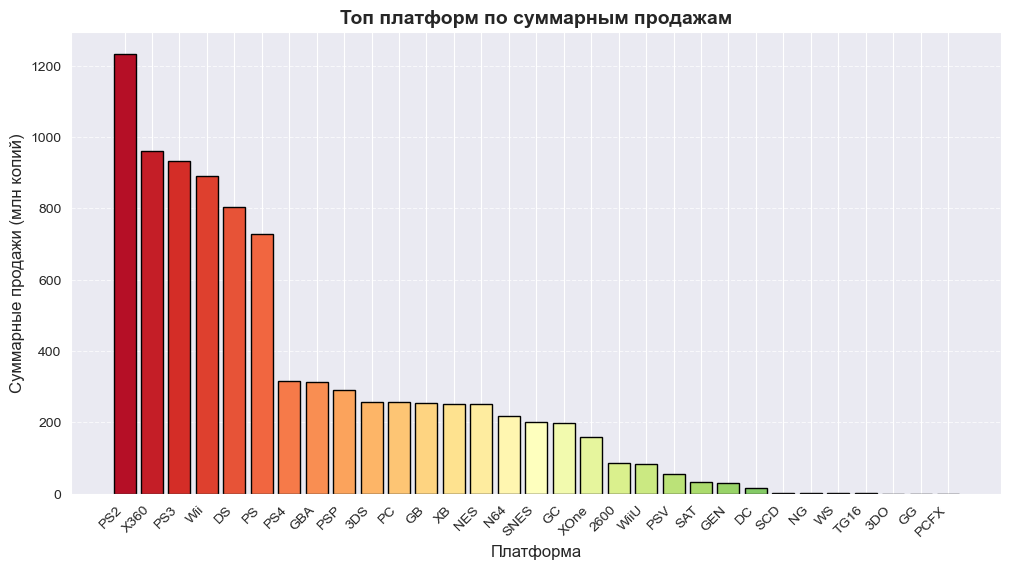

In [18]:
sales_by_platform = df.groupby('platform')['total_sales'].sum().sort_values(
    ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette("RdYlGn", len(sales_by_platform))

bars = ax.bar(sales_by_platform['platform'], sales_by_platform['total_sales'],
              color=colors, edgecolor='black')

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Топ платформ по суммарным продажам', fontsize=14, fontweight='bold')
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Суммарные продажи (млн копий)', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=10)

plt.show()


  Платформа  Суммарные продажи (млн копий)
0       PS2                    1233.559937
1      X360                     961.239990
2       PS3                     931.330017
3       Wii                     891.179993
4        DS                     802.780029
5        PS                     727.580017


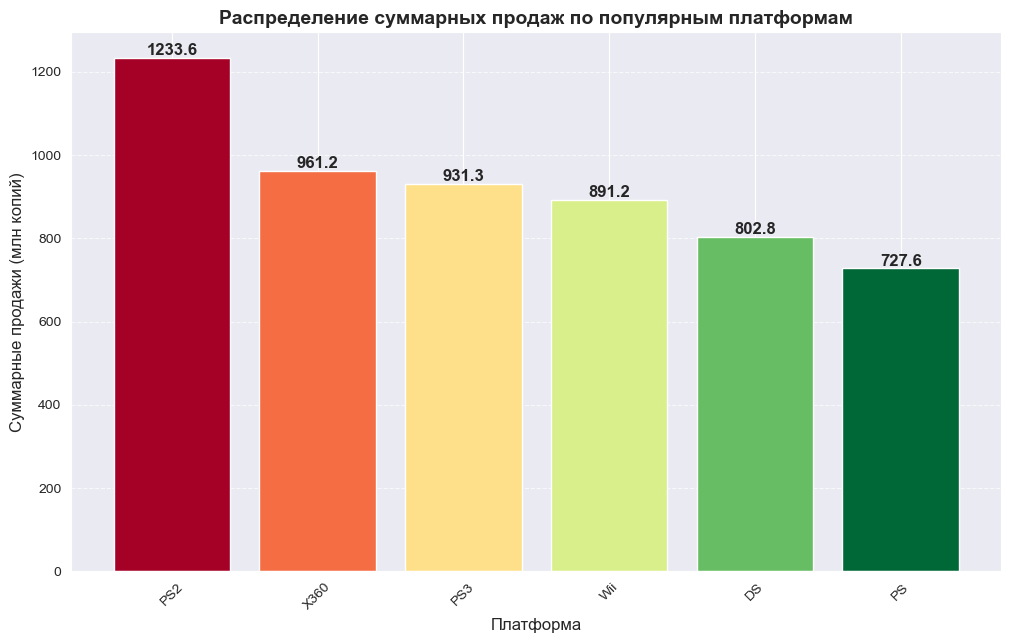

In [19]:
top6_sales_platform = sales_by_platform.head(6).copy()

top6_sales_platform.columns = ['Платформа', 'Суммарные продажи (млн копий)']

print(top6_sales_platform)

colors = cm.RdYlGn(np.linspace(0, 1, len(top6_sales_platform)))

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(top6_sales_platform['Платформа'],
              top6_sales_platform['Суммарные продажи (млн копий)'],
              color=colors)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Распределение суммарных продаж по популярным платформам',
          fontsize=14, fontweight='bold')
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Суммарные продажи (млн копий)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


**Промежуточный вывод:**
>_Лидерами по совокупному объему продаж за весь исследуемый период стали PS2, X360, Wii, PS3, DS и PS,  
что свидетельствует о значительном влиянии этих платформ на рынок видеоигр. При разработке  
бизнес-стратегий целесообразно ориентироваться на платформы последнего поколения, так как  
устаревшие устройства теряют поддержку производителей и перестают привлекать новых пользователей._

## ➢ Характерный период актуальности популярной платформы

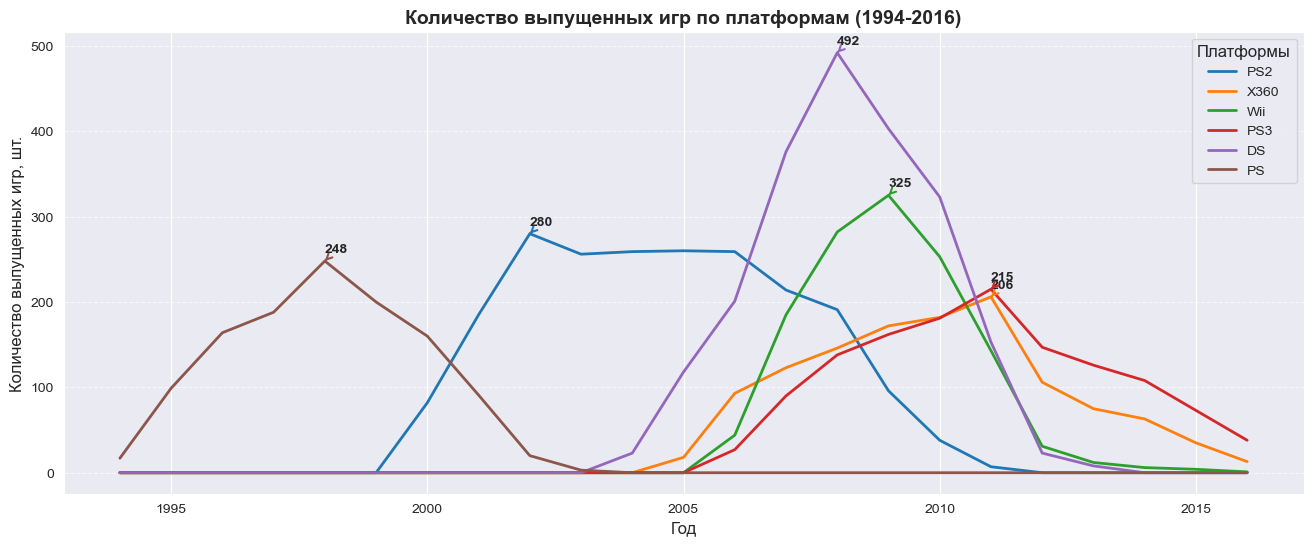

In [20]:
top_6_platforms = ['PS2', 'X360', 'Wii', 'PS3', 'DS', 'PS']

filtered_df = df[
    df['platform'].isin(top_6_platforms) & (df['year_of_release'] >= 1994) & (
            df['year_of_release'] <= 2016)
    ]

fig, ax = plt.subplots(figsize=(16, 6))
grouped_data = filtered_df.groupby(
    ['year_of_release', 'platform']).size().unstack()

sns.set_style("darkgrid")
palette = sns.color_palette("tab10", len(top_6_platforms))

for i, platform in enumerate(top_6_platforms):
    ax.plot(grouped_data.index, grouped_data[platform], label=platform,
            color=palette[i], linewidth=2)

    max_year = grouped_data[platform].idxmax()
    max_value = grouped_data[platform].max()
    ax.annotate(f'{int(max_value)}', xy=(max_year, max_value),
                xytext=(max_year, max_value + 10),
                fontsize=10, fontweight='bold',
                arrowprops=dict(arrowstyle='->', lw=1.5, color=palette[i]))

plt.title('Количество выпущенных игр по платформам (1994-2016)', fontsize=14,
          fontweight='bold')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество выпущенных игр, шт.', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Платформы", fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


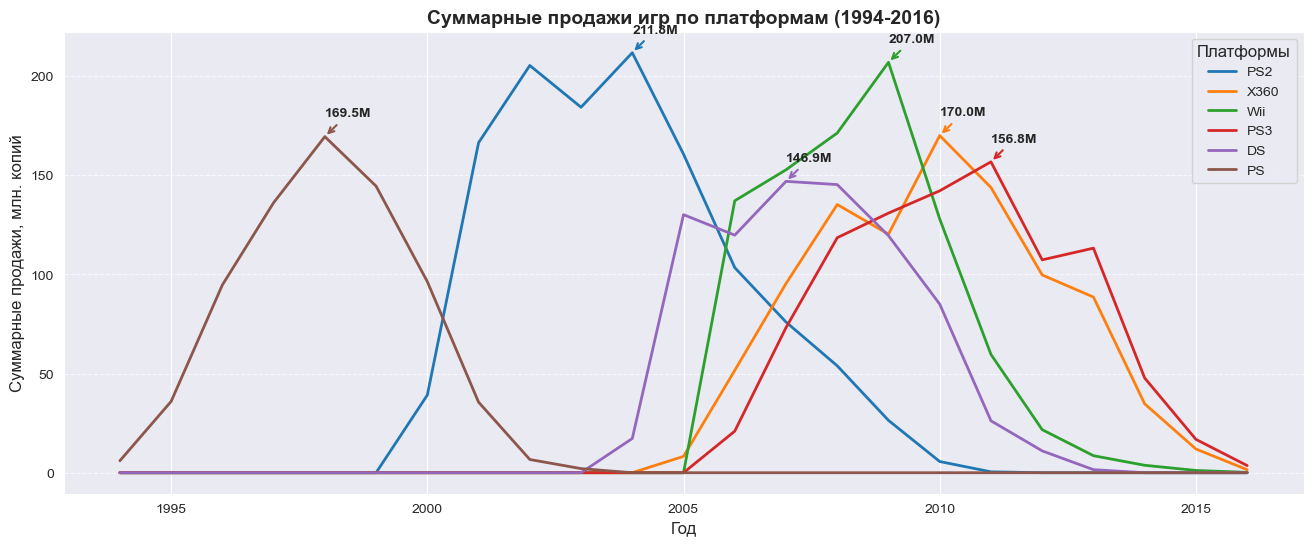

In [21]:
grouped_data = filtered_df.groupby(['year_of_release', 'platform'])[
    'total_sales'].sum().unstack()
sns.set_style("darkgrid")
palette = sns.color_palette("tab10", len(top_6_platforms))

fig, ax = plt.subplots(figsize=(16, 6))

for i, platform in enumerate(top_6_platforms):
    ax.plot(grouped_data.index, grouped_data[platform], label=platform,
            color=palette[i], linewidth=2)

    max_year = grouped_data[platform].idxmax()
    max_value = grouped_data[platform].max()
    ax.annotate(f'{max_value:.1f}M', xy=(max_year, max_value),
                xytext=(max_year, max_value + 10),
                fontsize=10, fontweight='bold',
                arrowprops=dict(arrowstyle='->', lw=1.5, color=palette[i]))

plt.title('Суммарные продажи игр по платформам (1994-2016)', fontsize=14,
          fontweight='bold')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Суммарные продажи, млн. копий', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Платформы", fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**Промежуточный вывод:**
>_Для обеспечения максимальной релевантности анализа были выбраны наиболее успешные платформы на  
рынке видеоигр за исследуемый период.Визуализация данных позволяет выявить закономерности жизненного  
цикла платформ: в среднем, пик популярности наступает спустя **4 года** после выхода, что  
сопровождается максимальным объемом выпускаемых игр. После достижения пика наблюдается  
закономерное снижение активности разработчиков, что свидетельствует об изменении спроса и  
переключении внимания индустрии на более современные технологии. В среднем, жизненный цикл  
платформы составляет около **7 лет**, в течение которых она остается привлекательной для выпуска новых игр.  
Дополнительно можно отметить влияние выхода новых поколений консолей: с запуском  
новых устройств количество выпускаемых игр для предыдущего поколения постепенно снижается,  
что отражает смещение интересов как разработчиков, так и потребителей в сторону более технологичных решений_

## ➢ Игровые платформы за актуальный период

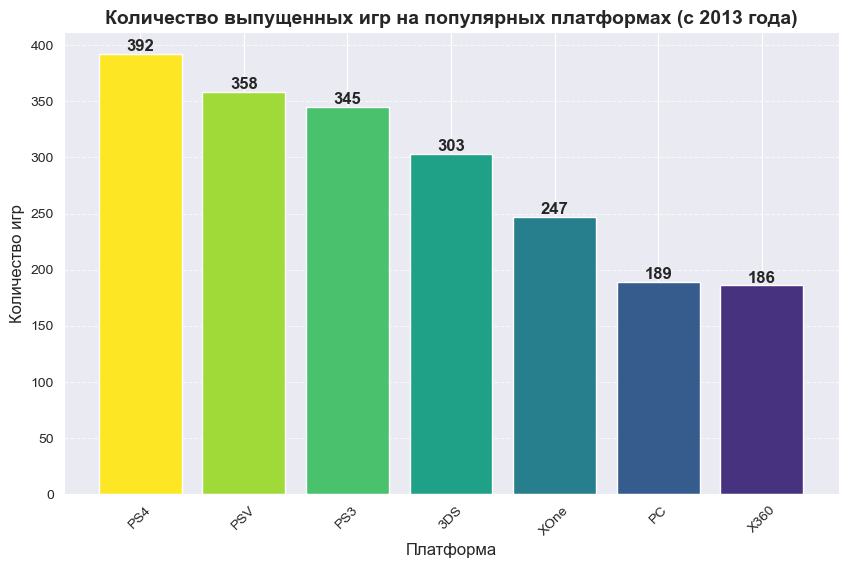

In [22]:
filtered_df = df[df['year_of_release'] >= 2013]
platform_counts = filtered_df['platform'].value_counts().head(7)

colors = [plt.cm.viridis_r(i / len(platform_counts)) for i in
          range(len(platform_counts))]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(platform_counts.index, platform_counts.values, color=colors)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Количество выпущенных игр на популярных платформах (с 2013 года)',
          fontsize=14, fontweight='bold')
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Количество игр', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## ➢ Количество тайтлов для различных платформ (Актуальный период)

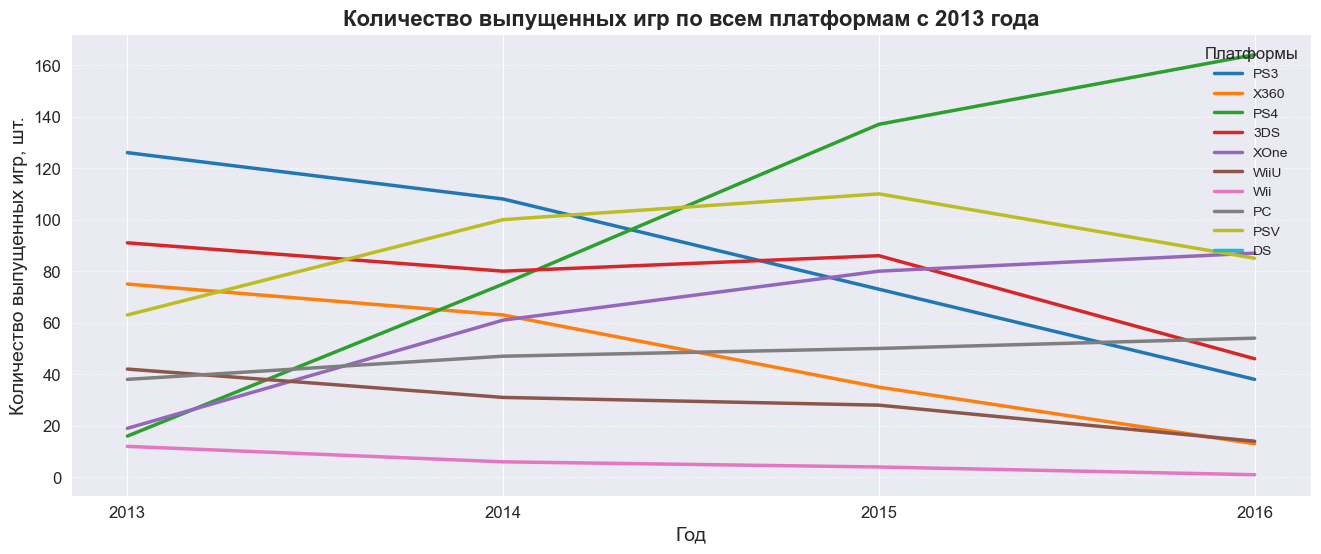

In [23]:
filtered_df = df[df['year_of_release'] >= 2013]

fig, ax = plt.subplots(figsize=(16, 6))

unique_platforms = filtered_df['platform'].unique()
colors = plt.cm.tab10.colors[:len(unique_platforms)]

for platform, color in zip(unique_platforms, colors):
    platform_data = filtered_df[filtered_df['platform'] == platform]
    grouped_data = platform_data.groupby('year_of_release').size()
    grouped_data.plot(ax=ax, label=platform, color=color, linewidth=2.5)

plt.title('Количество выпущенных игр по всем платформам с 2013 года',
          fontsize=16, fontweight='bold')
plt.xlabel('Год', fontsize=14)
plt.ylabel('Количество выпущенных игр, шт.', fontsize=14)
plt.xticks(np.arange(2013, 2017, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Платформы', fontsize=10, title_fontsize=12, loc='upper right',
           frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

## ➢ Суммарные продажи для различных платформ (Актуальный период)

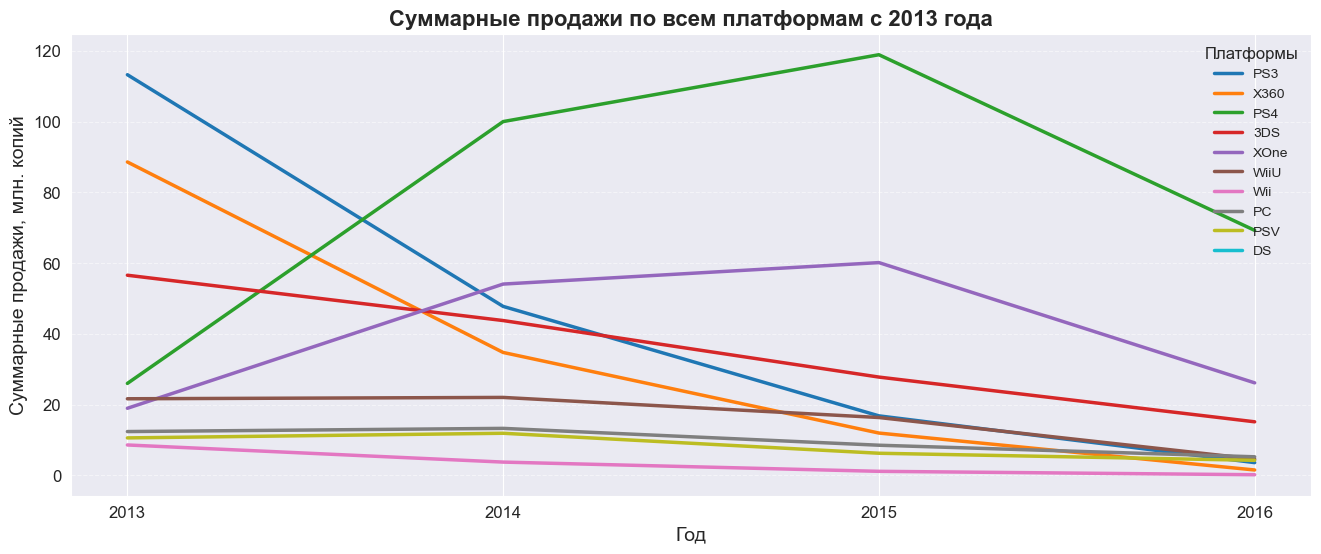

In [24]:
fig, ax = plt.subplots(figsize=(16, 6))

unique_platforms = filtered_df['platform'].unique()
colors = plt.cm.tab10.colors[:len(unique_platforms)]

for platform, color in zip(unique_platforms, colors):
    platform_data = filtered_df[filtered_df['platform'] == platform]
    grouped_data = platform_data.groupby('year_of_release')['total_sales'].sum()
    grouped_data.plot(ax=ax, label=platform, color=color, linewidth=2.5)

plt.title('Суммарные продажи по всем платформам с 2013 года', fontsize=16,
          fontweight='bold')
plt.xlabel('Год', fontsize=14)
plt.ylabel('Суммарные продажи, млн. копий', fontsize=14)
plt.xticks(np.arange(2013, 2017, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Платформы', fontsize=10, title_fontsize=12, loc='upper right',
           frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

**Визуализации распределений помогли понять, что ставку стоит сделать на PS4 и XOne, это единственные платформы которые после 2014 года демонстрировали рост продаж.**

**3DS всё еще остаётся популярной, так же, как и PC. Они так же попадают в рекомендательный лист на 2017 год.**

**Промежуточный вывод:**
>_Анализ визуализаций распределений показал, что наиболее перспективными платформами являются **PS4** и **XOne**,  
поскольку они единственные, кто демонстрировал рост продаж после 2014 года. **3DS** продолжает сохранять  
устойчивую популярность, сегмент **PC**-игр остается стабильным. Эти платформы также включены в  
список приоритетных направлений для 2017 года._

## ➢ Диаграммы размаха продаж по платформам

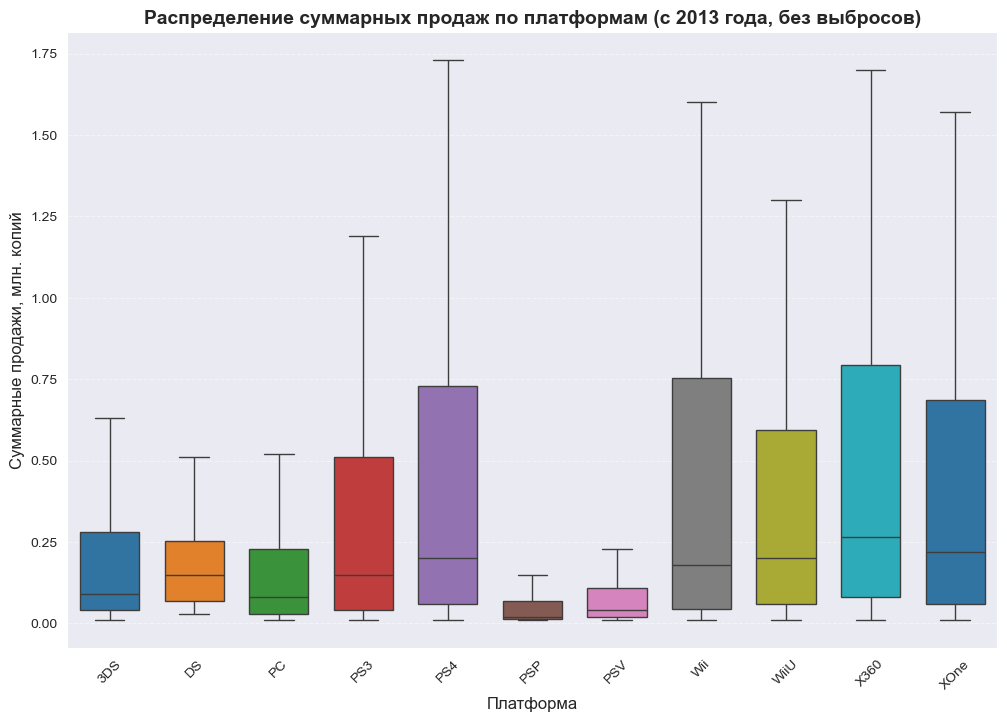

In [25]:
if pd.api.types.is_categorical_dtype(filtered_df['platform']):
    filtered_df['platform'] = filtered_df[
        'platform'].cat.remove_unused_categories()

non_zero_platforms = filtered_df.groupby('platform')['total_sales'].sum()
non_zero_platforms = non_zero_platforms[non_zero_platforms > 0].index
filtered_df = filtered_df[filtered_df['platform'].isin(non_zero_platforms)]

plt.figure(figsize=(12, 8))

colors = sns.color_palette("tab10", len(filtered_df['platform'].unique()))

sns.boxplot(data=filtered_df, x='platform', y='total_sales', showfliers=False,
            palette=colors, width=0.7)

plt.title(
    'Распределение суммарных продаж по платформам (с 2013 года, без выбросов)',
    fontsize=14, fontweight='bold')
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Суммарные продажи, млн. копий', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

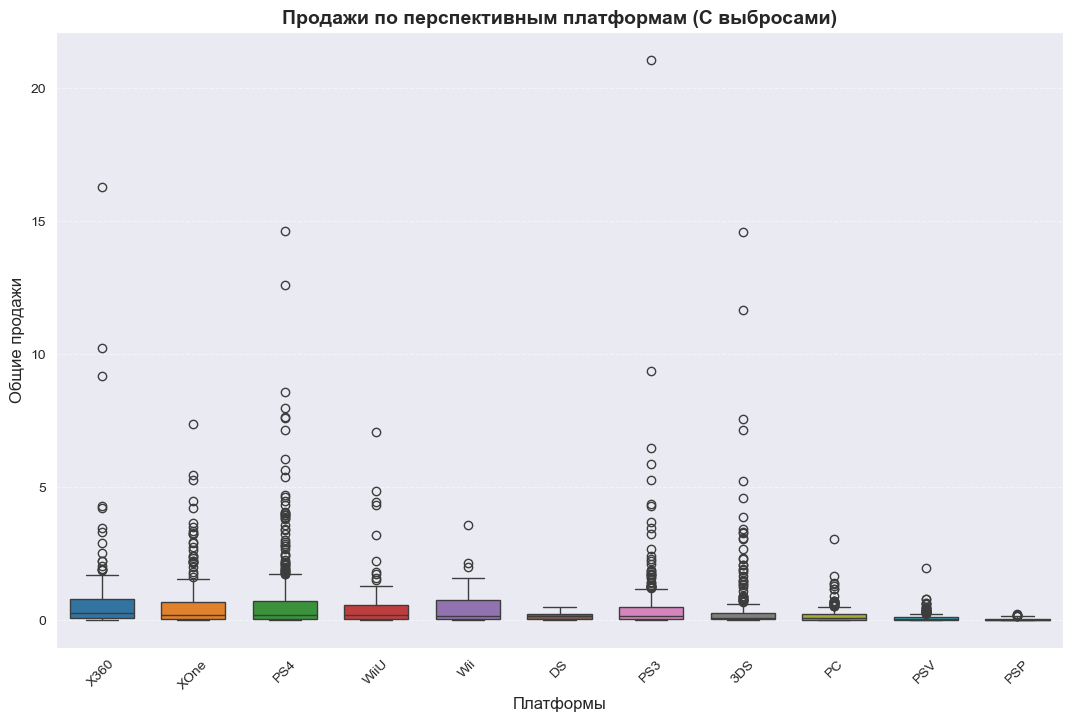

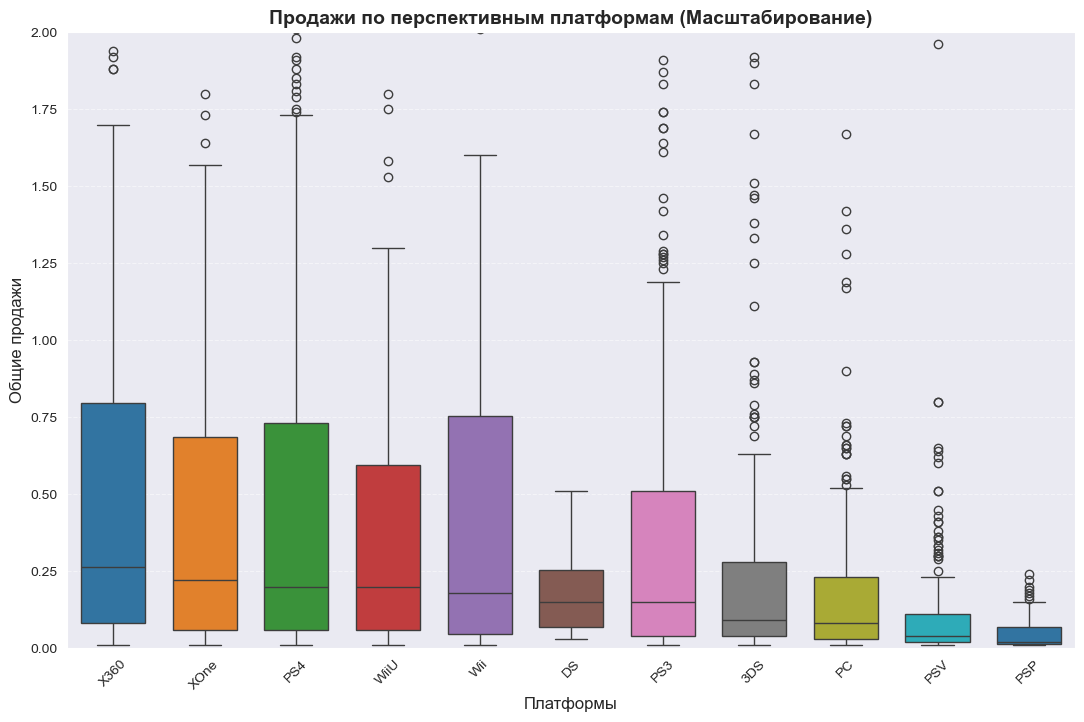

In [26]:
data_temp, y = filtered_df.copy(), 'total_sales'
data_temp['platform'] = data_temp['platform'].astype('str')

plt.figure(figsize=(13, 8))

colors = sns.color_palette("tab10", len(data_temp['platform'].unique()))

sns.boxplot(
    data=data_temp,
    y=y,
    x='platform',
    order=data_temp.groupby('platform')[y].median().sort_values(
        ascending=False).index,
    palette=colors,
    width=0.7
)

plt.title('Продажи по перспективным платформам (С выбросами)', fontsize=14,
          fontweight='bold')
plt.xlabel('Платформы', fontsize=12)
plt.ylabel('Общие продажи', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

plt.figure(figsize=(13, 8))

sns.boxplot(
    data=data_temp,
    y=y,
    x='platform',
    order=data_temp.groupby('platform')[y].median().sort_values(
        ascending=False).index,
    palette=colors,
    width=0.7
)

plt.title('Продажи по перспективным платформам (Масштабирование)', fontsize=14,
          fontweight='bold')
plt.xlabel('Платформы', fontsize=12)
plt.ylabel('Общие продажи', fontsize=12)
plt.ylim(0, 2)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


**Промежуточный вывод:**
>_Значительная часть платформ, представленных в наборе утратила свою актуальность.  
Создание механизма фильтрации экстремальных значений, с высокой долей вероятности,  
приведёт к смещению оценки, ведь многие игры, которые продаются гигантскими  
тиражами, получают статус "культовых". Пользователи приобретают ту или иную  
платформу только ради одной, супер-успешной игры. Вместо фильтрации можно  
рассмотреть диаграмму размаха с масштабированием.  
Получившаяся картинка соответствует ожиданиям, XOne, X360, PS4, PS3  
имеют широкий IQR, это свойственно топовым платформам, игр выходит много,  
как успешных, так и не очень. При выдвижении гипотез, относительно рынка  
PC-игр, стоит учитывать распространения пиратства, несмотря на это, платформа  
так же не лишена множества экстремальных значений._

## ➢ Влияние оценок пользователей и критиков на продажи
_Для начала исследуем данные по продажам в сегменте PS4, он является одним из  
наиболее репрезентативных._

Корреляция между отзывами критиков и продажами для платформы PS4:
                   Оценки критиков  Суммарные продажи
Оценки критиков           1.000000           0.406568
Суммарные продажи         0.406568           1.000000


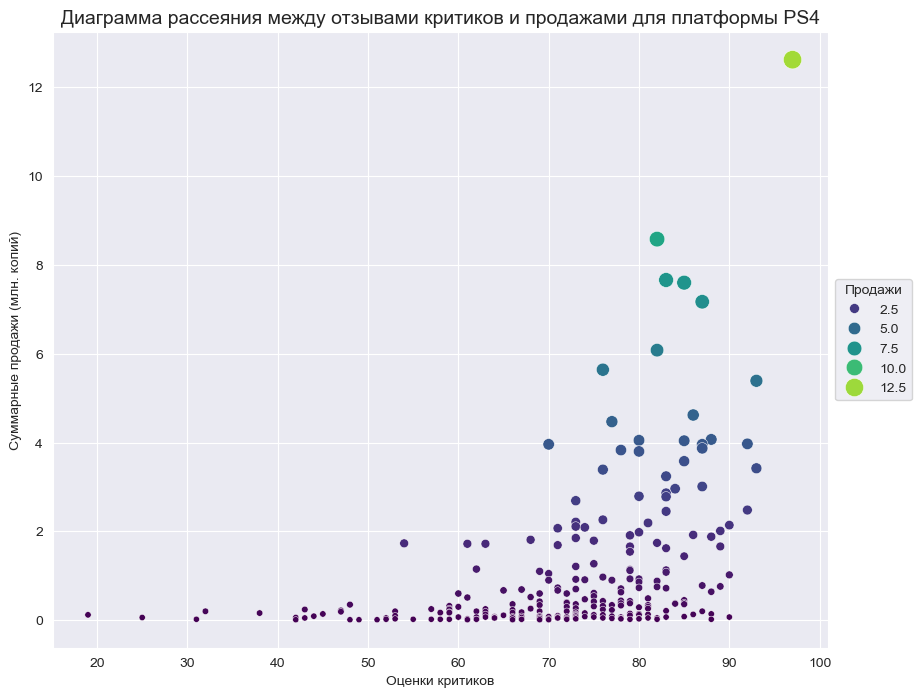

In [27]:
filtered_df_ps4 = filtered_df[filtered_df['platform'] == 'PS4']
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=filtered_df_ps4, x='critic_score',
                               y='total_sales', hue='total_sales',
                               size='total_sales', palette='viridis',
                               sizes=(20, 200))

correlation = filtered_df_ps4[['critic_score', 'total_sales']].corr()
correlation = correlation.rename(index={'critic_score': 'Оценки критиков',
                                        'total_sales': 'Суммарные продажи'})
correlation = correlation.rename(columns={'critic_score': 'Оценки критиков',
                                          'total_sales': 'Суммарные продажи'})

print('Корреляция между отзывами критиков и продажами для платформы PS4:')
print(correlation)

plt.title(
    'Диаграмма рассеяния между отзывами критиков и продажами для платформы PS4',
    size=14)
plt.xlabel('Оценки критиков')
plt.ylabel('Суммарные продажи (млн. копий)')
scatter_plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Продажи')
plt.show()


Корреляция между отзывами пользователей и продажами для платформы PS4:
                      Отзывы пользователей  Суммарные продажи
Отзывы пользователей              1.000000          -0.031957
Суммарные продажи                -0.031957           1.000000


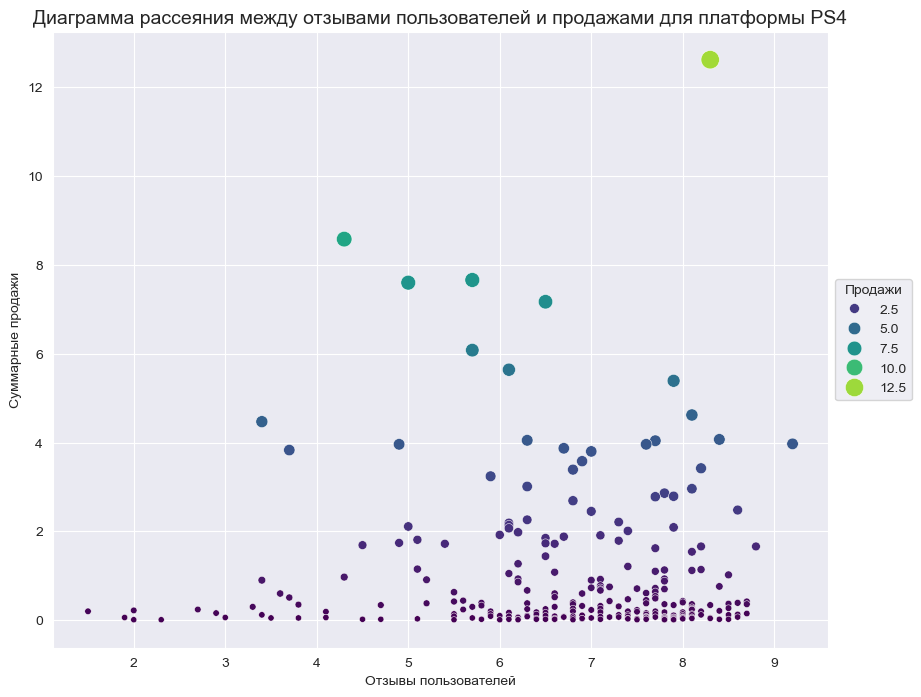

In [28]:
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=filtered_df_ps4, x='user_score',
                               y='total_sales', hue='total_sales',
                               size='total_sales', palette='viridis',
                               sizes=(20, 200))

correlation = filtered_df_ps4[['user_score', 'total_sales']].corr()
correlation = correlation.rename(index={'user_score': 'Отзывы пользователей',
                                        'total_sales': 'Суммарные продажи'})
correlation = correlation.rename(columns={'user_score': 'Отзывы пользователей',
                                          'total_sales': 'Суммарные продажи'})

print('Корреляция между отзывами пользователей и продажами для платформы PS4:')
print(correlation)

plt.title(
    'Диаграмма рассеяния между отзывами пользователей и продажами для платформы PS4',
    size=14)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Суммарные продажи')
scatter_plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Продажи')
plt.show()


**Промежуточный вывод:**
>_Данные говорят о том, что оценки критиков имеют весьма заметное влияние на  
общие продажи продукта, тогда как пользовательские оценки не имеют хоть  
сколько-нибудь выраженную корреляцию с целевым показателем._

## ➢ Инспекция оставшихся игровых платформ

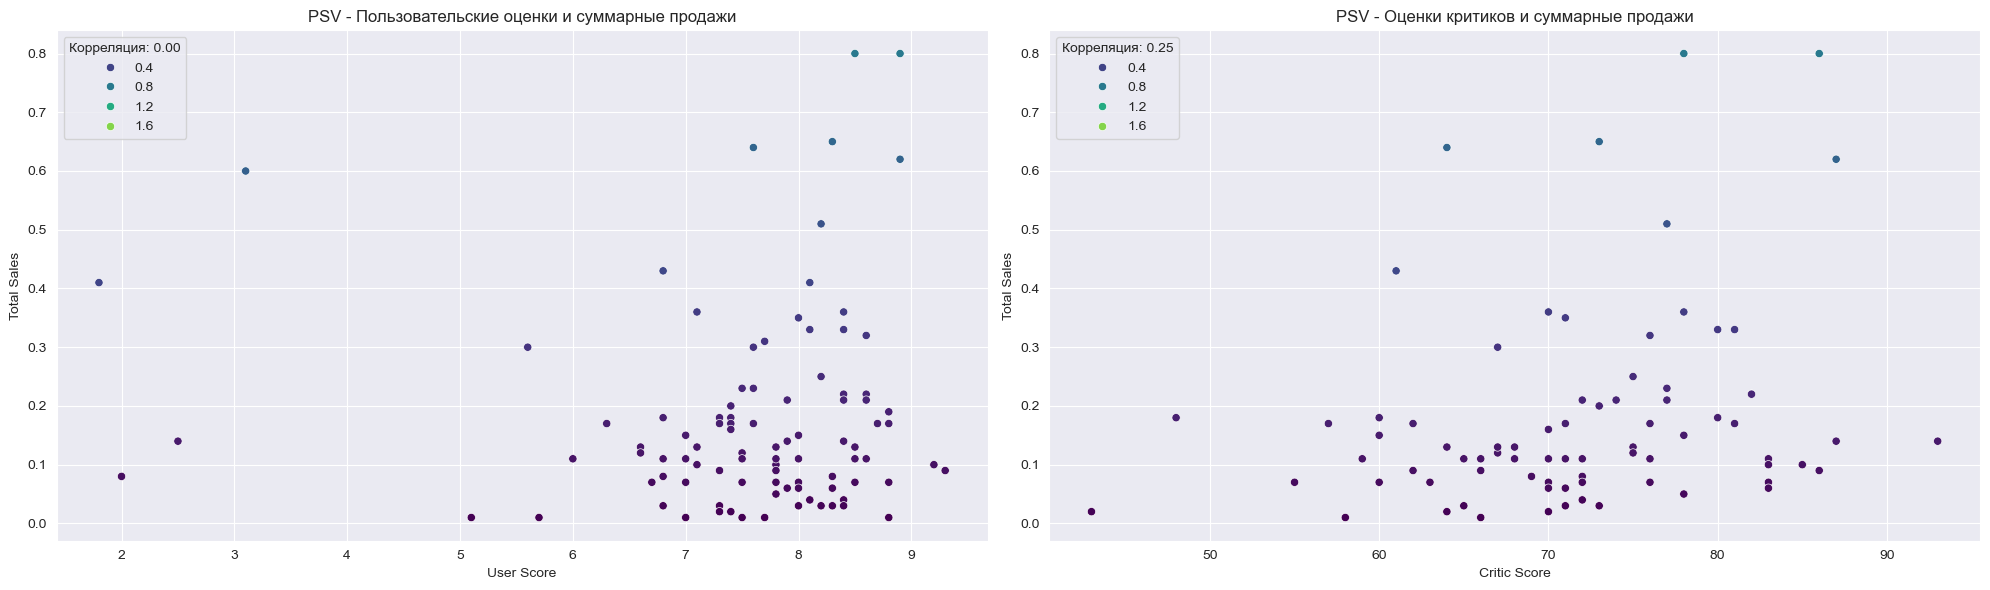

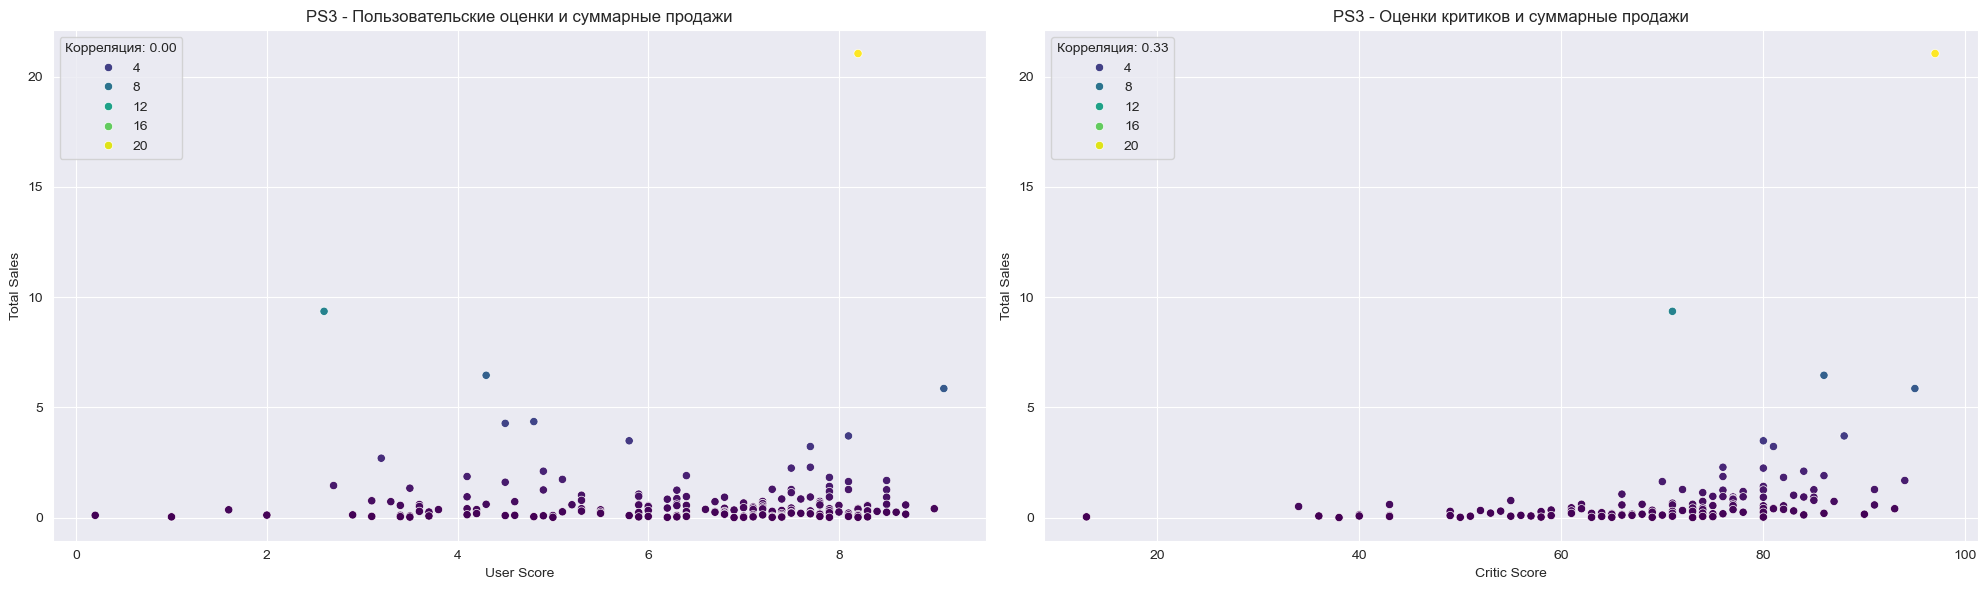

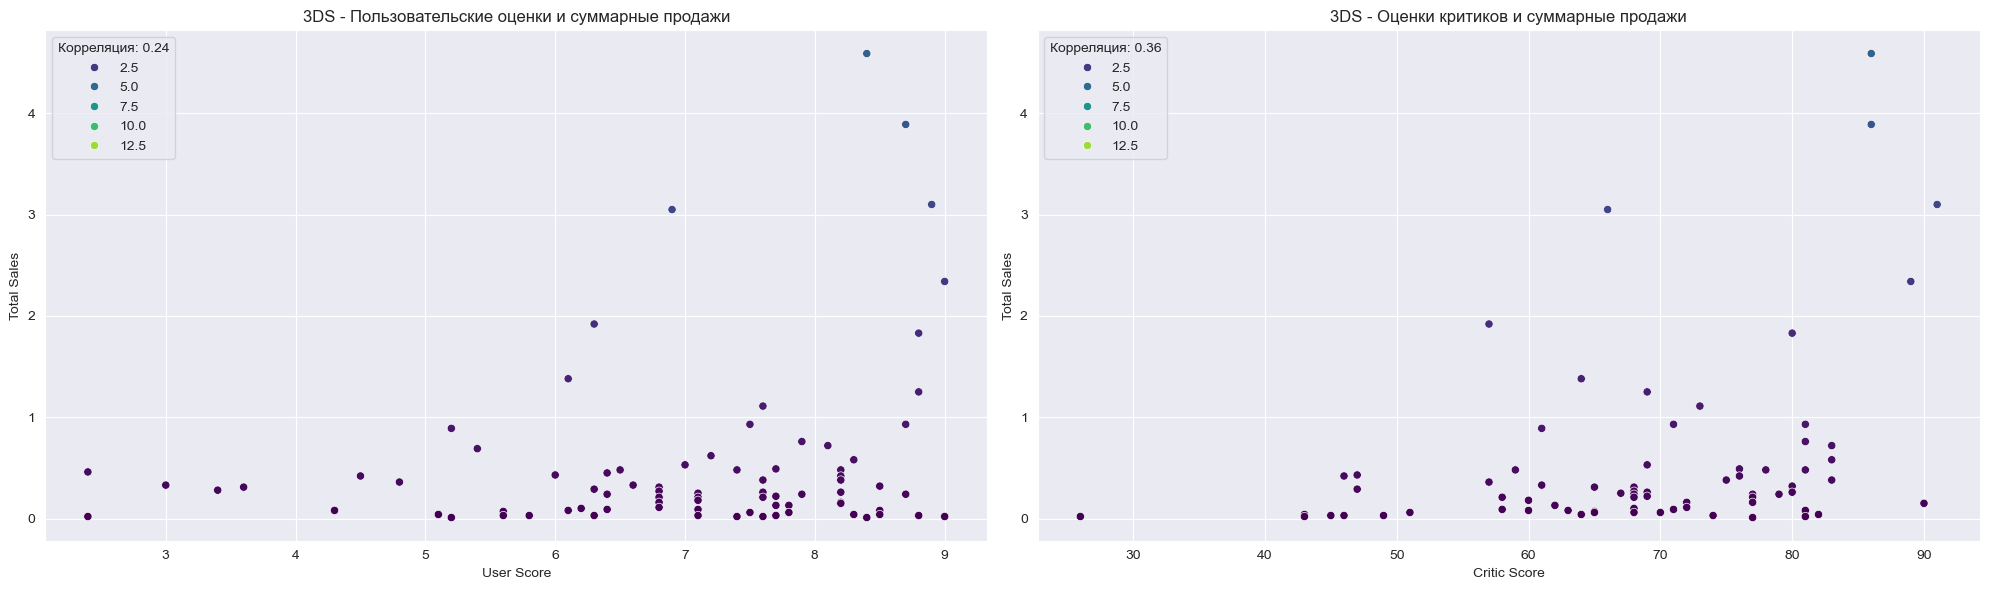

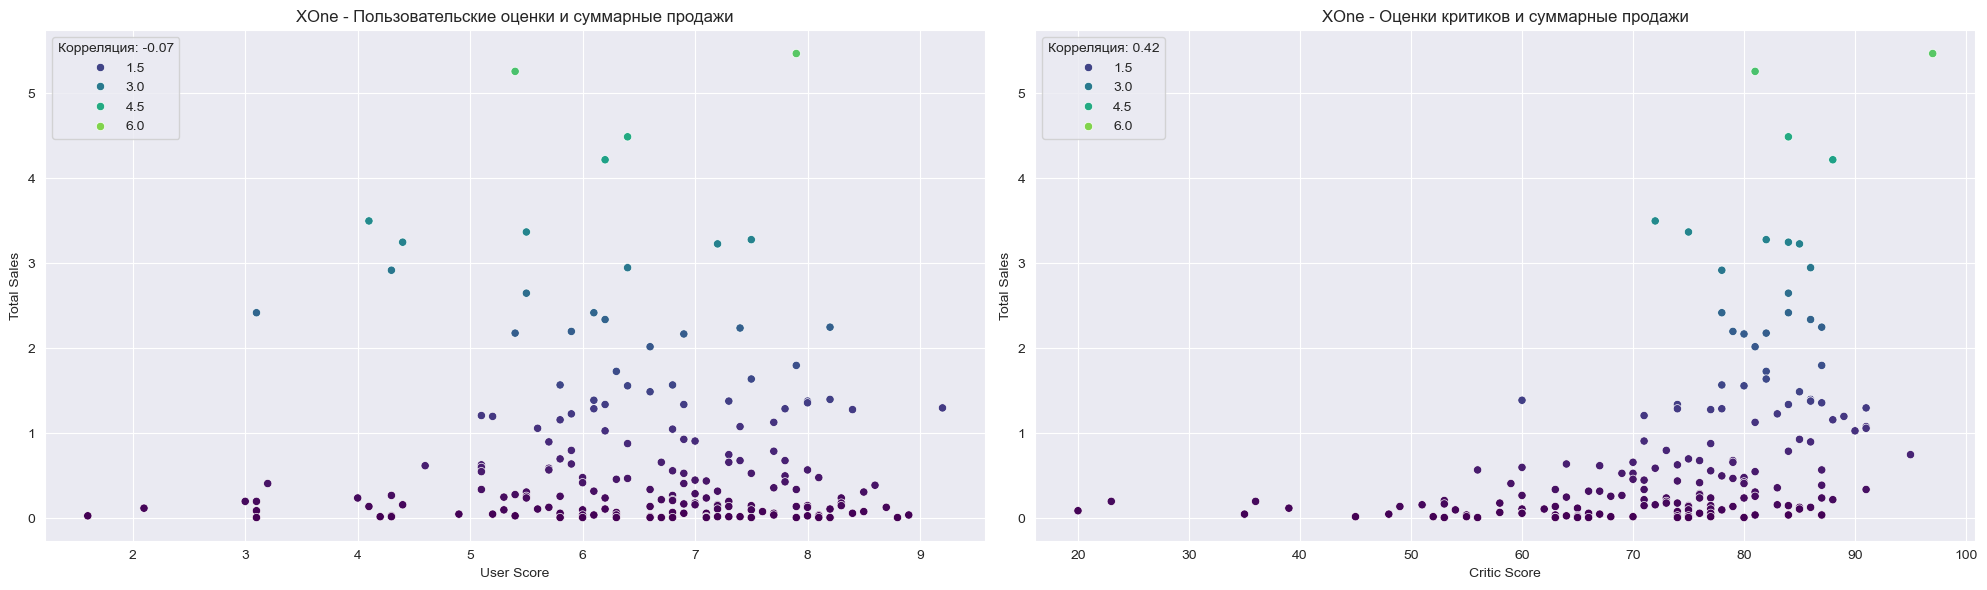

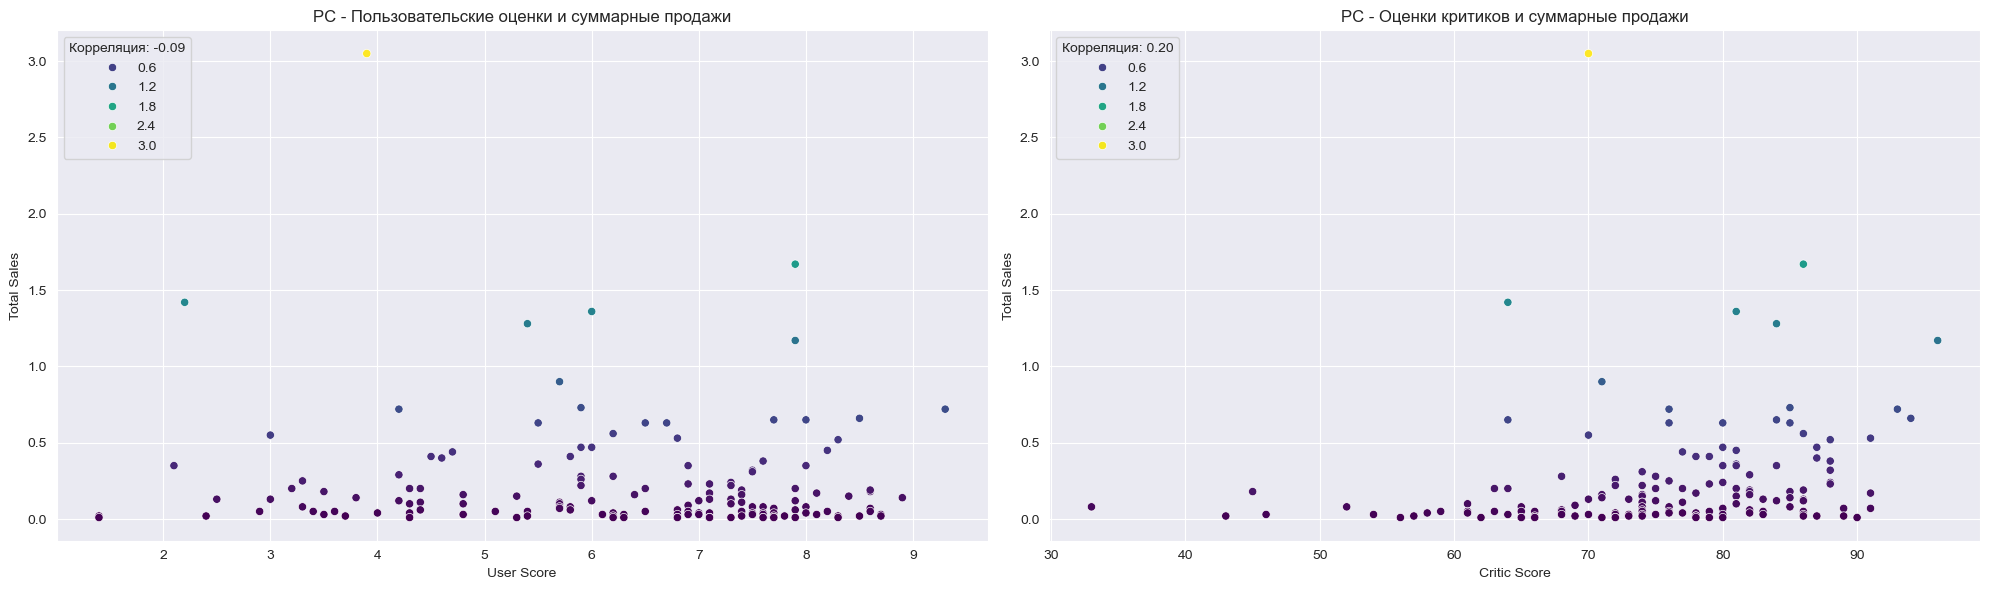

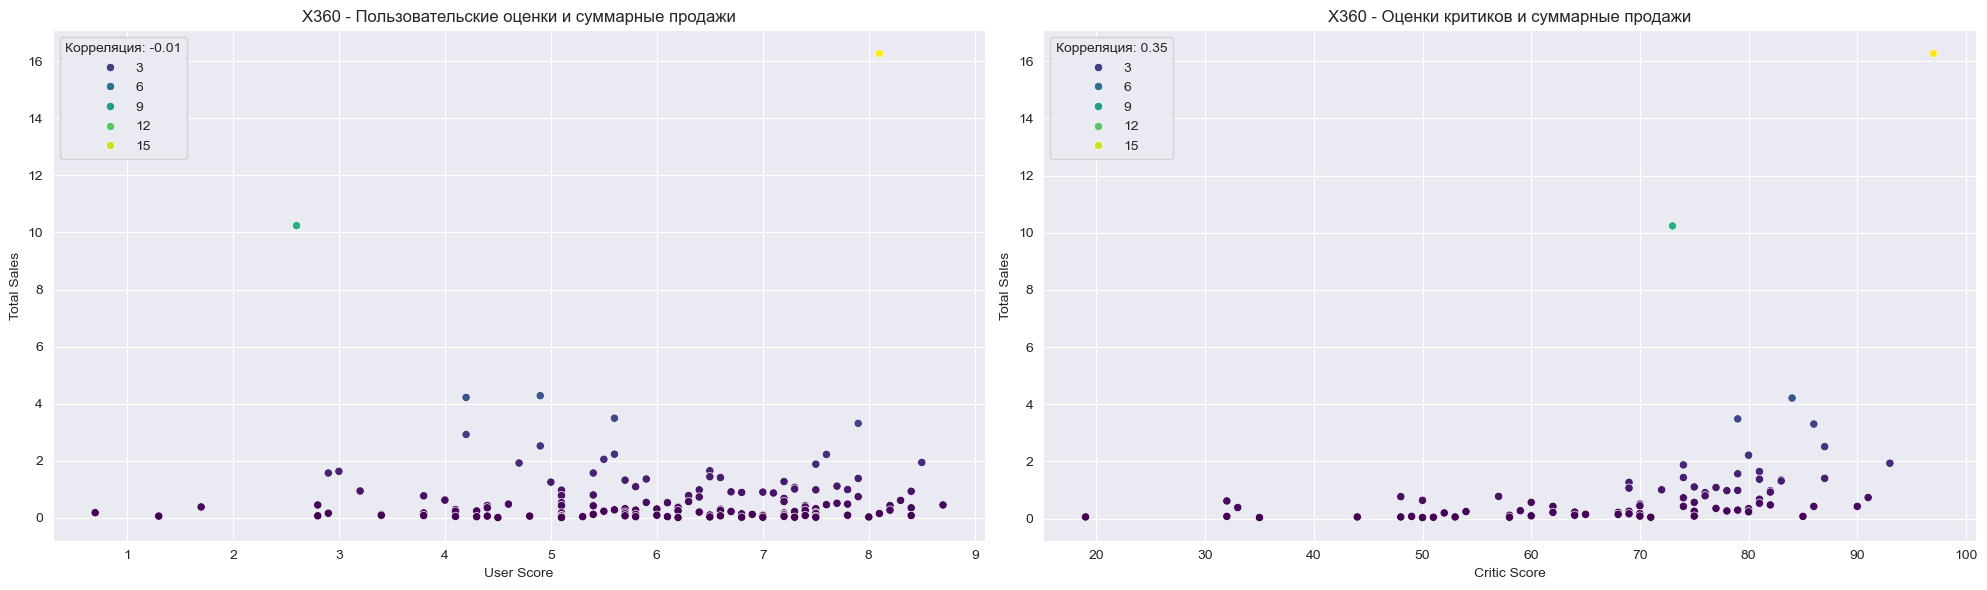

In [29]:
platforms = ['PSV', 'PS3', '3DS', 'XOne', 'PC', 'X360']

for platform in platforms:
    platform_df = filtered_df[filtered_df['platform'] == platform]

    user_corr = platform_df[['user_score', 'total_sales']].corr().iloc[0, 1]

    critic_corr = platform_df[['critic_score', 'total_sales']].corr().iloc[0, 1]

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    sns.scatterplot(data=platform_df, x='user_score', y='total_sales',
                    ax=axes[0], hue='total_sales', palette='viridis')
    axes[0].set_title(
        f'{platform} - Пользовательские оценки и суммарные продажи')
    axes[0].set_xlabel('User Score')
    axes[0].set_ylabel('Total Sales')
    axes[0].legend(title=f'Корреляция: {user_corr:.2f}', loc='upper left')

    sns.scatterplot(data=platform_df, x='critic_score', y='total_sales',
                    ax=axes[1], hue='total_sales', palette='viridis')
    axes[1].set_title(f'{platform} - Оценки критиков и суммарные продажи')
    axes[1].set_xlabel('Critic Score')
    axes[1].set_ylabel('Total Sales')
    axes[1].legend(title=f'Корреляция: {critic_corr:.2f}', loc='upper left')

    plt.tight_layout()
    plt.show()


**Для всех отобранных платформ, за актуалный период выраженной корреляции между отзывами игроков и суммарными продажами не наблюдается нигде, кроме**

**платформы 3DS, там значение оказалось равным 0.24.**

**Оценки критиков оказывают существенное влияние на суммарные продажи для всех платформ. Рекорд установил XOne, со значением в  0.4!**

**В целом можно сказать, что для ранее выделенной платформы - PS4, наблюдались аналогичные показатели! Оценки пользователей несущественно влияют на продажи**

**а оценки критиков в среднем оказывают серьёзное влияние на продажи.**

## ➢ Распределение игр по жанрам

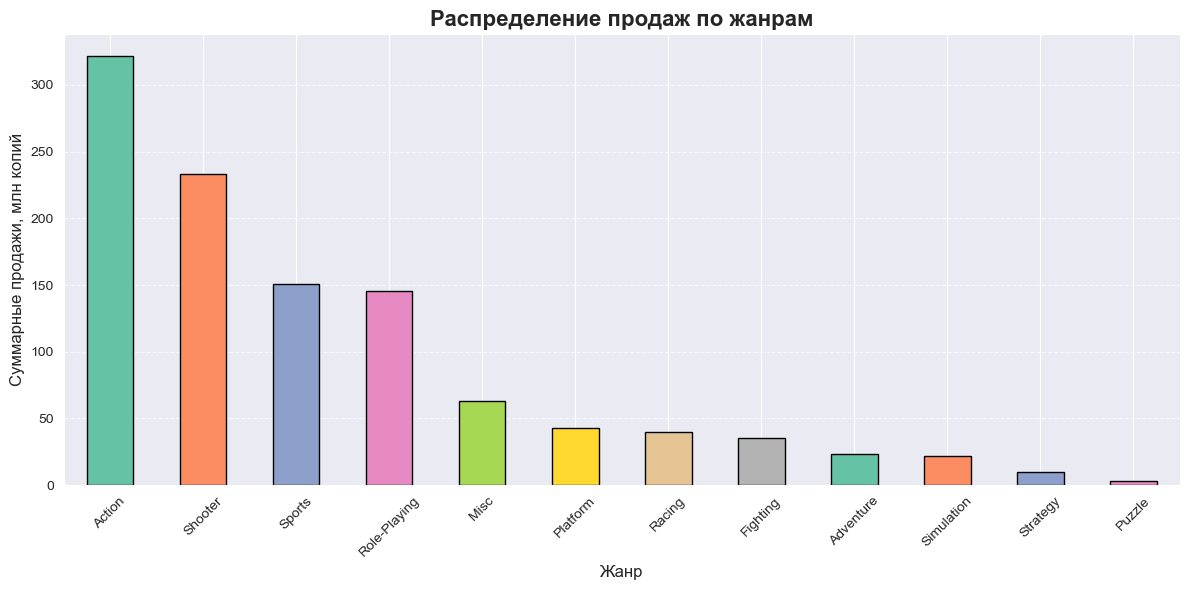

In [30]:
genre_sales = filtered_df.groupby('genre')['total_sales'].sum().sort_values(
    ascending=False)

plt.figure(figsize=(12, 6))

genre_sales.plot(kind='bar', color=sns.color_palette("Set2", len(genre_sales)),
                 edgecolor='black')

plt.title('Распределение продаж по жанрам', fontsize=16, fontweight='bold')
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Суммарные продажи, млн копий', fontsize=12)

plt.xticks(rotation=45, fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()


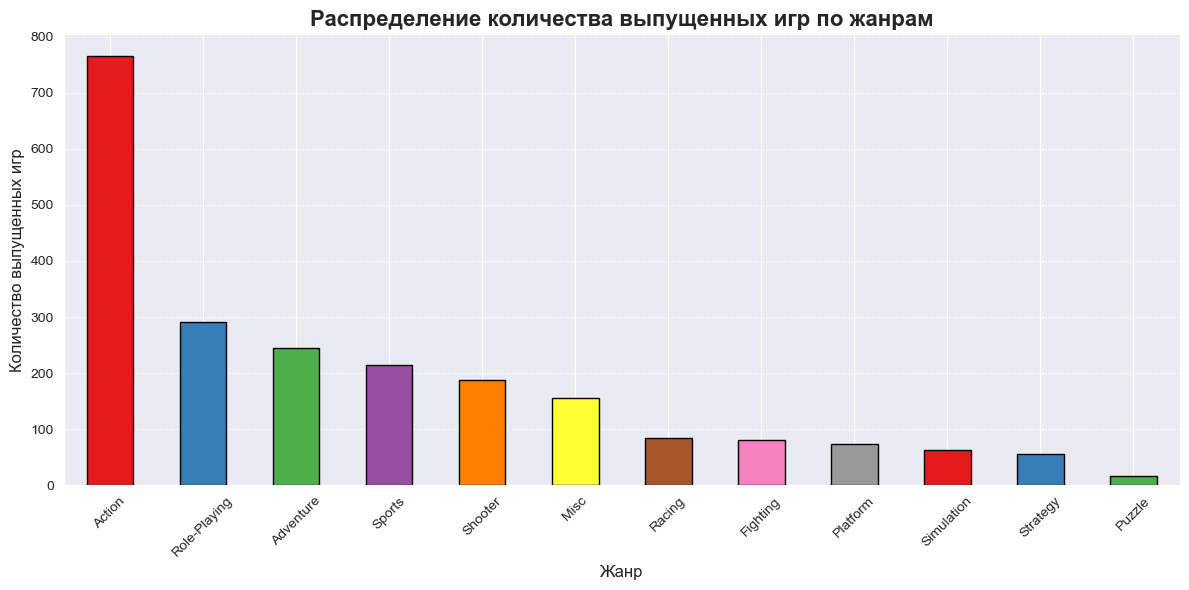

In [31]:
genre_count = filtered_df.groupby('genre').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
genre_count.plot(kind='bar', color=sns.color_palette("Set1", len(genre_count)),
                 edgecolor='black')

plt.title('Распределение количества выпущенных игр по жанрам', fontsize=16,
          fontweight='bold')
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Количество выпущенных игр', fontsize=12)

plt.xticks(rotation=45, fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()


**Промежуточный вывод:**
>_Первую тройку лидеров продаж ожидаемо занимают активные жанры игр, такие как Action,  
затем, с небольшим отрывом Shooter. Самыми небольшими тиражами расходятся неторопливые  
жанры - головоломки, стратегии. Игровые студии делают упор на выпуске на рынок  
Action, Rpg, Adventure - жанров. Достаточно и спортивных симуляторов.  
Лучше разобраться в ситуации на рынке поможет сводная таблица, рассмотрим её ниже._

In [32]:
genre_counts = filtered_df.groupby('genre')['total_sales'].count()
mean_sales = filtered_df.groupby('genre')['total_sales'].mean()

pivot_table = pd.DataFrame(
    {'Общее количество игр': genre_counts, 'Средние продажи': mean_sales})
pivot_table

,Общее количество игр,Средние продажи
genre,,
Action,766,0.420196
Adventure,245,0.096490
Fighting,80,0.441375
Misc,155,0.405290
Platform,74,0.576081
Puzzle,17,0.186471
Racing,85,0.469294
Role-Playing,292,0.499623
Shooter,187,1.245882


**Промежуточный вывод:**
>_Жанр Action подтверждает правило: "Спрос рождает предложение", имея огромное количество  
проектов и весьма высокие средние продажи. Шутеры и RPG занимают значительную  
долю рынка и однозначно интересны пользователям, среди платформеров находятся  
несколько культовых тайтлов, которые обеспечивают колоссальные доходы своим  
издателям. Автосимы и спортсимы схожи, как по динамике, так и по показателям  
продаж._

## Вывод шага Ⅲ:  
> В 1995 году сформировалась тенденция к устойчивому росту количества выпускаемых в год игр.  
Пик пришёлся на 2008-2009 годы, после чего произошёл резкий спад количества релизов.  
Лидерами по продажам за всё время оказались PS2, X360, Wii, PS3, DS, PS.  
На пик популярности платформа выходит около 4 лет, после чего начинается закономерный спад количества выпускаемых игр.  
Можно ожидать, что платформа будет актуальна около 7 лет.  
Визуализации распределений помогли понять, что ставку стоит сделать на PS4 и XOne — это единственные платформы, которые после 2014 года демонстрировали рост продаж.  
3DS всё еще остаётся популярной, так же, как и PC. Они также попадают в рекомендательный лист на 2017 год.  
Оценки критиков безусловно оказывают влияние на объем продаж: чем выше оценка, тем больше копий продано.  
Первую пару лидеров продаж ожидаемо занимают активные жанры игр, такие как Action, затем, с небольшим отрывом — Shooter.  
Жанры Action, adventure и RPG являются лидерами по количеству выпускаемых на рынок продуктов.

# IV Шаг. Портрет пользователя для каждого региона

## ➢ Топ-5 популярных платформ

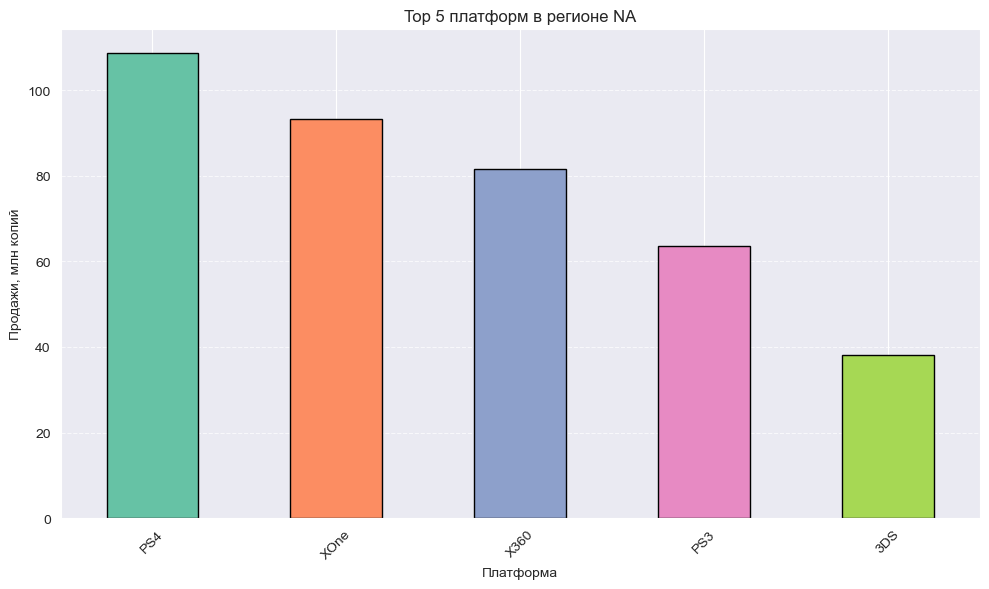

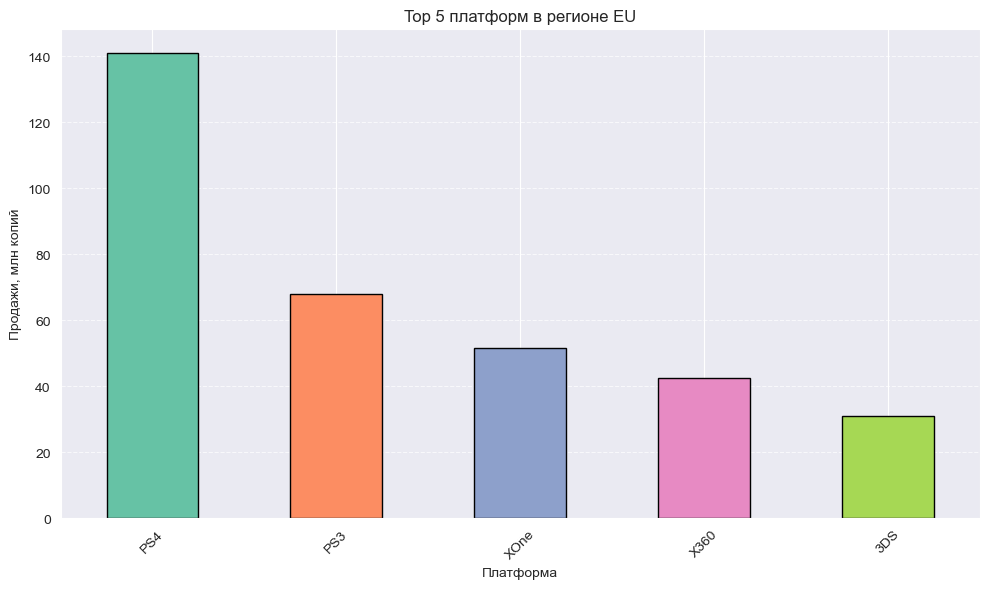

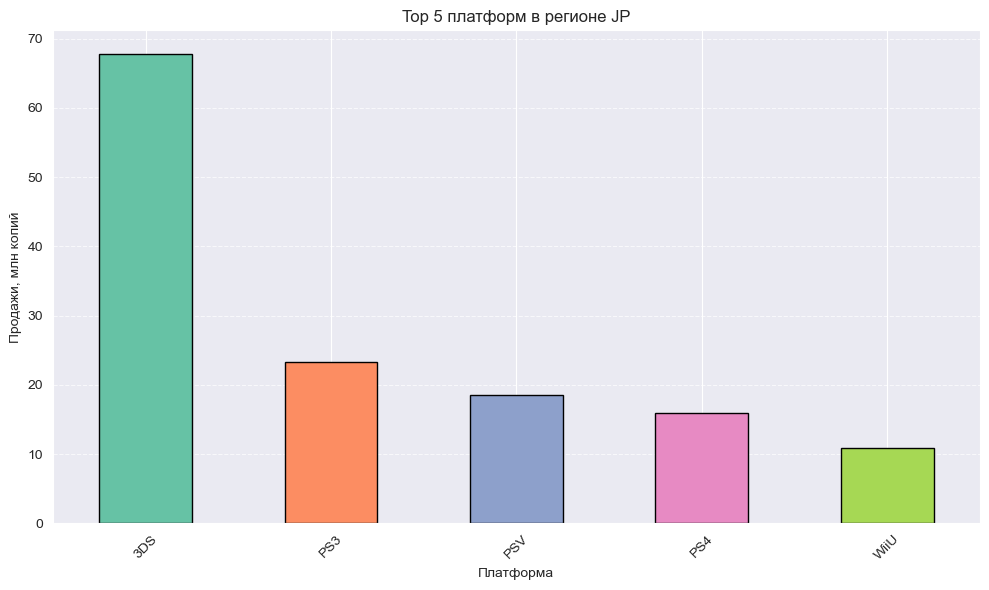

In [33]:
regions = ['na_sales', 'eu_sales', 'jp_sales']

for region in regions:
    region_users_df = filtered_df[filtered_df[region].notnull()]
    region_platform_sales = region_users_df.groupby('platform')[region].sum()
    top_5_platforms = region_platform_sales.nlargest(5)

    plt.figure(figsize=(10, 6))
    top_5_platforms.plot(kind='bar',
                         color=sns.color_palette("Set2", len(top_5_platforms)),
                         edgecolor='black')
    plt.title(f"Top 5 платформ в регионе {region[:-6].upper()}")
    plt.xlabel('Платформа')
    plt.ylabel('Продажи, млн копий')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


**Промежуточный вывод:**
>_В Северной Америке и Европе пользователи активно покупают консольные издания,  
и лидером продаж является новая PS4! Европейцы предпочитают PlayStation, на  
втором месте находится PS3, тогда как в Северной Америке PS3 заняла лишь 4-е место,  
а серебро и бронзу заслужили американские консоли XBox One и XBox 360.  
В Японии пользователи отдают явное предпочтение Nintendo 3DS, что, безусловно,  
связано с тем, что JP — родина этой легендарной консоли. В Европе и Северной Америке  
3DS также популярна, занимая 5-е место в обоих регионах. Остальные 4 позиции  
японские геймеры отдали своим отечественным консольным продуктам, а PS4 пока  
находится на 4-м месте, но всё ещё впереди._


## ➢ Топ-5 популярных жанров

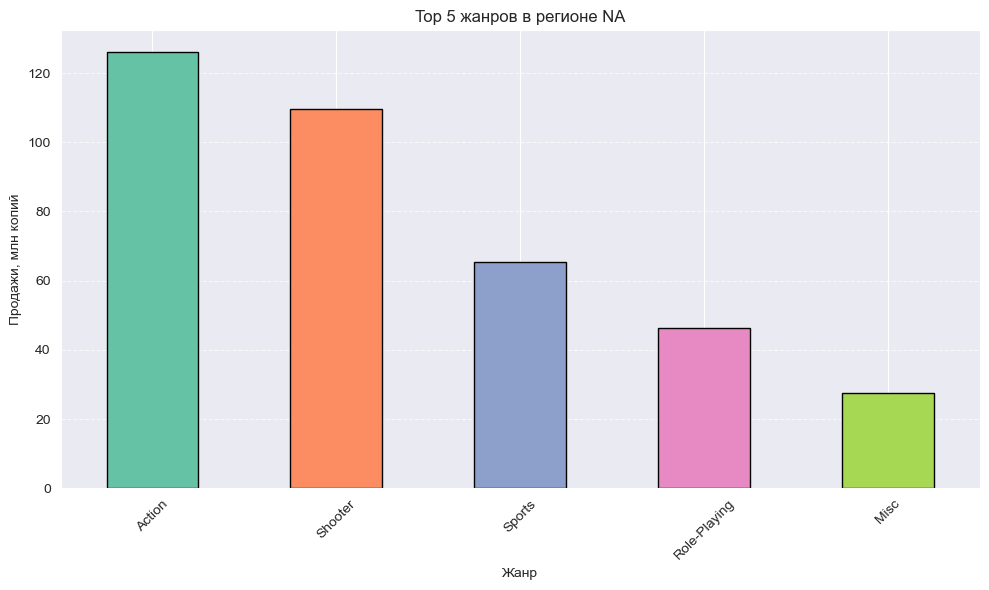

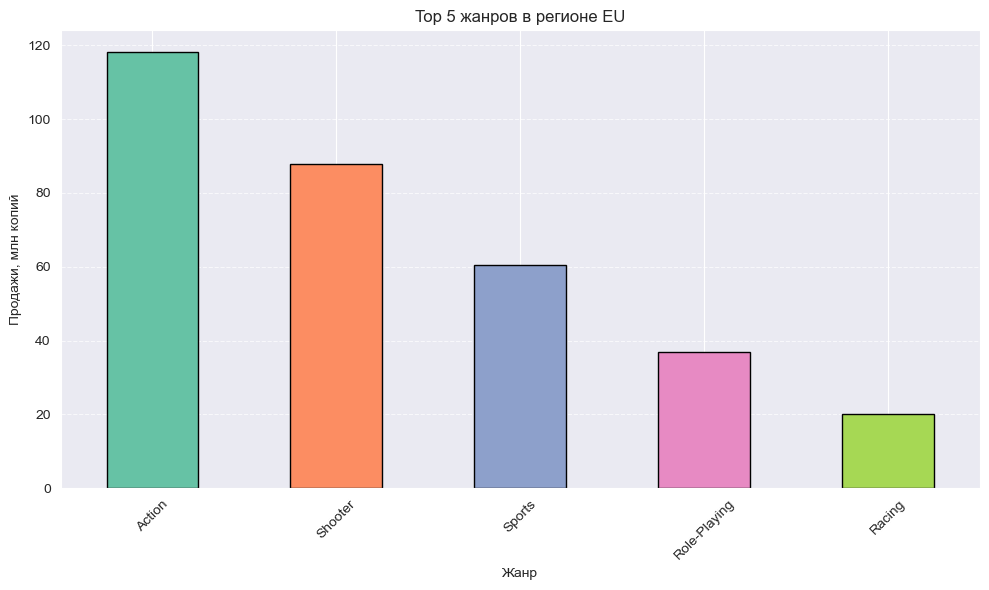

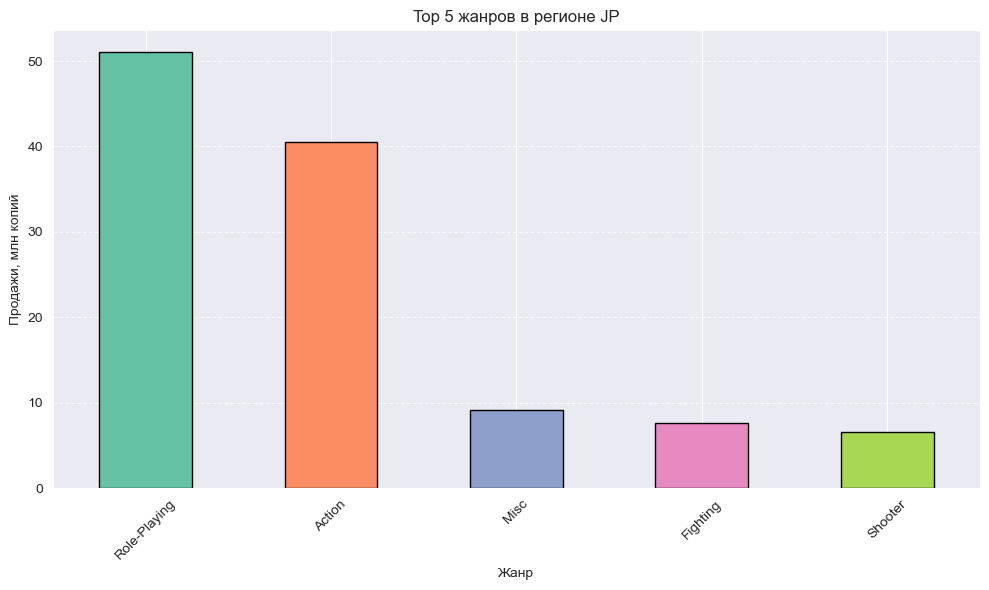

In [34]:
for region in regions:
    region_users_df = filtered_df[filtered_df[region].notnull()]
    region_genre_sales = region_users_df.groupby('genre')[region].sum()
    top_5_genres = region_genre_sales.nlargest(5)

    plt.figure(figsize=(10, 6))
    top_5_genres.plot(kind='bar',
                      color=sns.color_palette("Set2", len(top_5_genres)),
                      edgecolor='black')
    plt.title(f"Top 5 жанров в регионе {region[:-6].upper()}")
    plt.xlabel('Жанр')
    plt.ylabel('Продажи, млн копий')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


**Промежуточный вывод:**
>_Геймеры из Европы и Северной Америки сходятся в том, что активно покупают игры жанров  
Action и Shooter. Пользователям из Японии тоже нравятся Action-игры, но их фаворитом  
стали RPG тайтлы. Спортивные симуляторы заняли 3-е место по популярности среди  
европейцев и американцев, а у японских потребителей они вовсе не попали в топ-5.  
Зато в Японии пользователи любят fighting-игры, которые заняли 4-е место в топе продаж._

_Дополнительно рассмотрим, какие же игры вывели жанр Role-Playing в JP  
регионе на первое место по популярности_

In [35]:
jp_rp_df = filtered_df[
    (filtered_df['genre'] == 'Role-Playing') & (df['jp_sales'].notnull())]
top_5 = jp_rp_df.groupby('name')['jp_sales'].sum().nlargest(5)
top_5

name
Pokemon X/Pokemon Y                          4.35
Monster Hunter 4                             3.44
Yokai Watch 2 Ganso/Honke                    3.18
Pokemon Omega Ruby/Pokemon Alpha Sapphire    3.10
Yokai Watch 2 Shinuchi                       2.68
Name: jp_sales, dtype: float32

## ➢ Влияние рейтинга ESRB на продажи

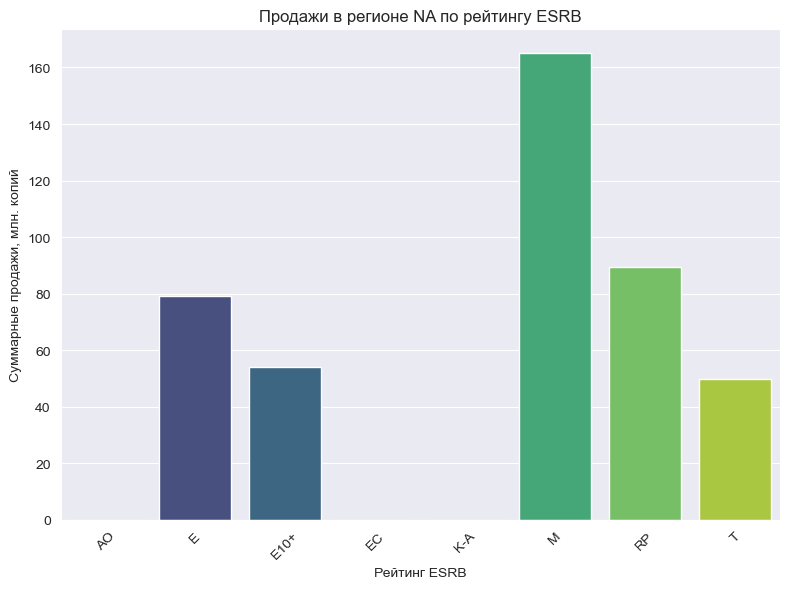

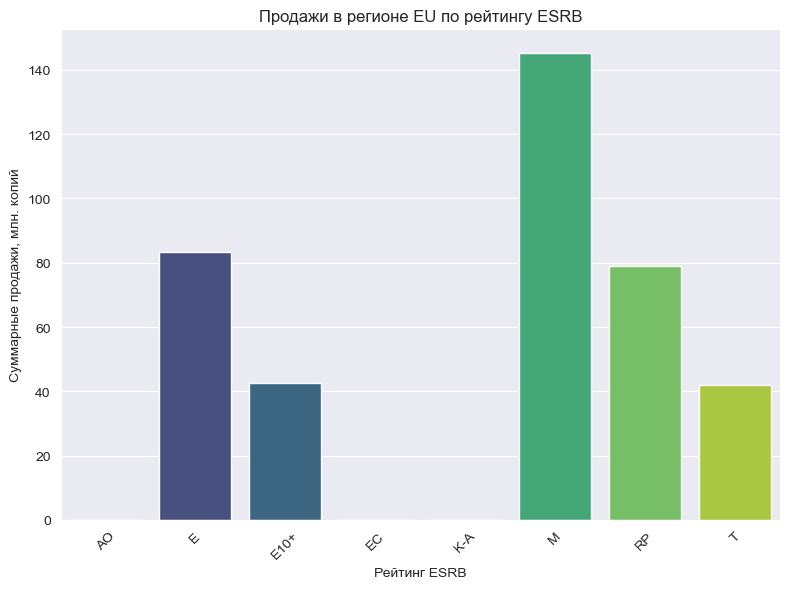

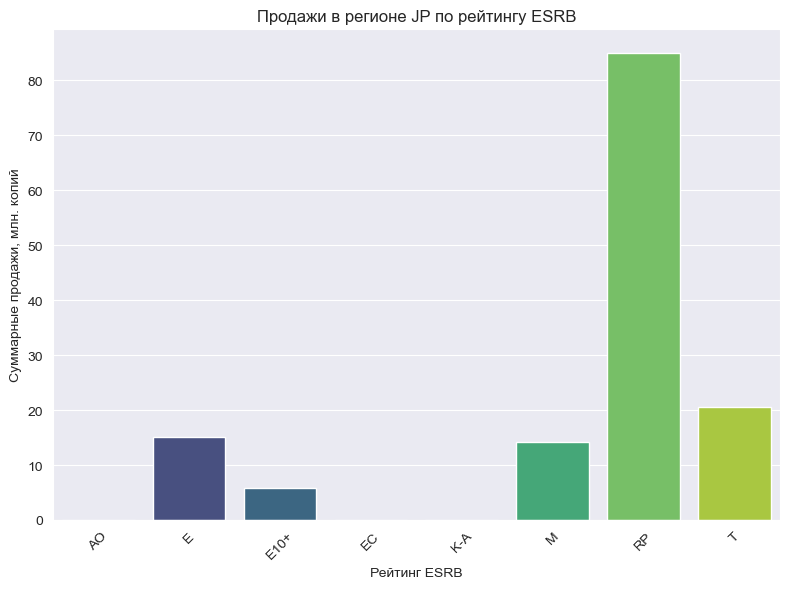

In [36]:
regions = [('na', 'na_sales'), ('eu', 'eu_sales'), ('jp', 'jp_sales')]

for region, sales_column in regions:
    filtered_ratings_df = filtered_df[filtered_df['rating'].notnull()]

    pivot_table = filtered_ratings_df.pivot_table(index='rating',
                                                  values=sales_column,
                                                  aggfunc='sum')
    pivot_table_sorted = pivot_table.sort_values(by=sales_column,
                                                 ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=pivot_table_sorted.index, y=pivot_table_sorted[sales_column],
                palette='viridis')
    plt.title(f'Продажи в регионе {region.upper()} по рейтингу ESRB')
    plt.xlabel('Рейтинг ESRB')
    plt.ylabel('Суммарные продажи, млн. копий')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Промежуточный вывод:**
>_Пользователи из Европы и Северной Америки имеют схожее распределение, большая  
часть продаваемых игр имеет рейтинг M — mature. Можно сказать, что игры с подобным  
рейтингом будут иметь высокие шансы продаться большим тиражом в этих регионах.  
В Японии мы видим несколько иную ситуацию: там потребители предпочитают рейтинг  
T — teen, либо в равных долях E — everyone. Следует отметить, что значительная часть  
игр, которые покупают японцы, не имеет актуального рейтинга._

## Вывод шага IV:
> В Северной Америке и Европе доминирует консоль PS4. Европейцы отдают предпочтение  
PlayStation, а в Северной Америке XBox One и XBox 360 на 2 и 3 местах.  
В Японии лидирует Nintendo 3DS, связанная с локальным производителем.  
В Eu и NA 3DS также в топ-5, а японцы предпочитают свои консоли, включая PS4 на 4 месте.  
Жанры Action и Shooter стабильно популярны в NA и Eu. В Японии также ценят Action,  
но лидирует RPG. Спортивные симуляторы на 3 месте среди европейцев и  
американцев, а в Японии они не попали в топ-5. В JP пользователи предпочитают  
fighting-игры, занявшие 4-е место. Для NA и Европы характерна высокая популярность  
игр с рейтингом M (mature), что свидетельствует о больших объемах продаж в этих  
регионах. В Японии предпочитают игры с рейтингом T (teen) или E (everyone),  
при этом значительная часть игр не имеет рейтинга.

# V Шаг. Проверка гипотез
_В пояснительной записке, заказчиком исследования был приведён перечень  
гипотез, подлежащих статистической проверке._

## ➢ Гипотеза о равентсве средних показателей пользовательских рейтингов

**H0: Средние пользовательские рейтинги платформ XOne и PC одинаковые**

**H1: Средние пользовательские рейтинги платформ XOne и PC различаются**

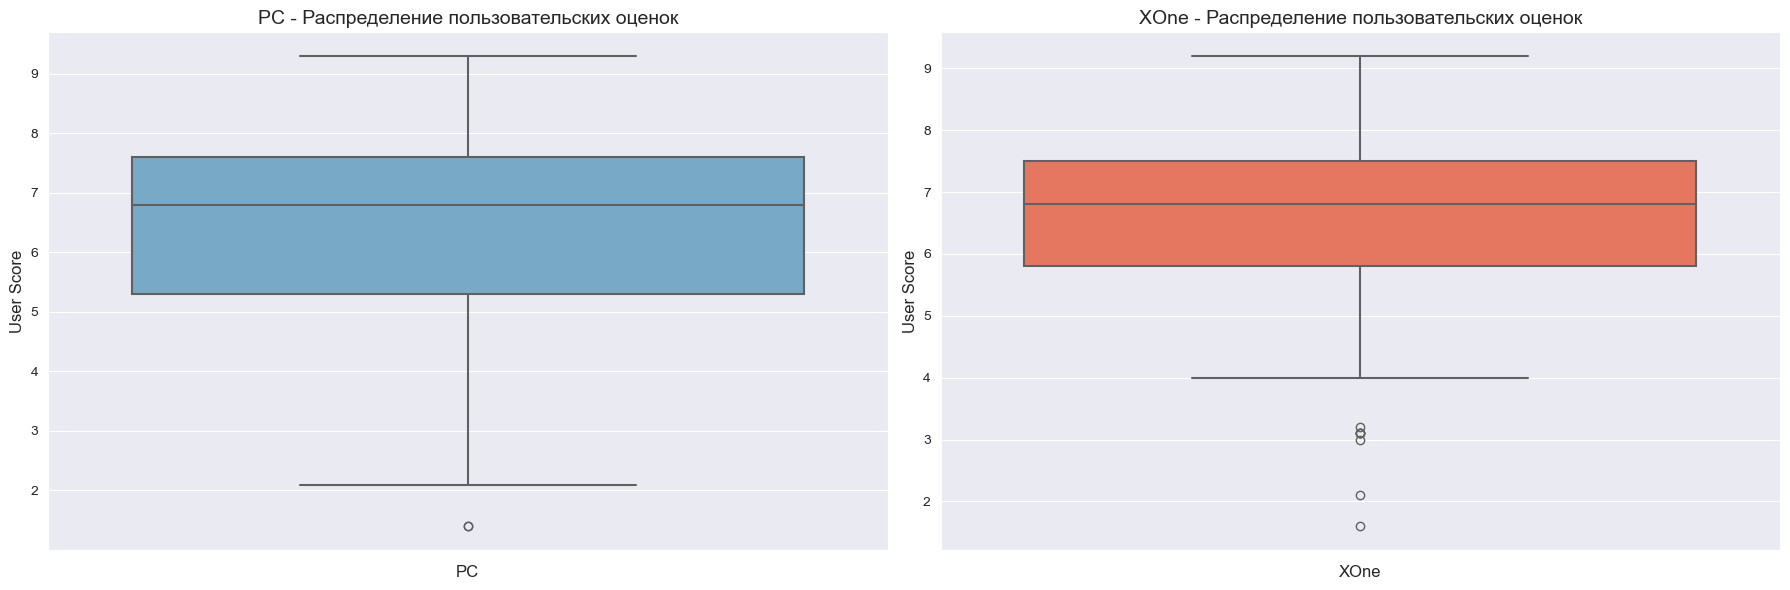

In [37]:
alpha = .05

pc_scores = filtered_df.query('platform == "PC"')['user_score'].dropna()
xone_scores = filtered_df.query('platform == "XOne"')['user_score'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=pc_scores, palette="Blues", showfliers=True, linewidth=1.5,
            ax=axes[0])
axes[0].set_title('PC - Распределение пользовательских оценок', fontsize=14)
axes[0].set_xlabel('PC', fontsize=12)
axes[0].set_ylabel('User Score', fontsize=12)

sns.boxplot(data=xone_scores, palette="Reds", showfliers=True, linewidth=1.5,
            ax=axes[1])
axes[1].set_title('XOne - Распределение пользовательских оценок', fontsize=14)
axes[1].set_xlabel('XOne', fontsize=12)
axes[1].set_ylabel('User Score', fontsize=12)

plt.tight_layout()
plt.show()

In [38]:
res = st.ttest_ind(pc_scores, xone_scores)

print("p-Value:", res.pvalue)

if res.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-Value: 0.14012765210016784
Не получилось отвергнуть нулевую гипотезу


## ➢ Гипотеза о равенстве средних пользовательских рейтингов Action и Sports

**H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые**

**H1: Средние пользовательские рейтинги жанров Action и Sports различаются**

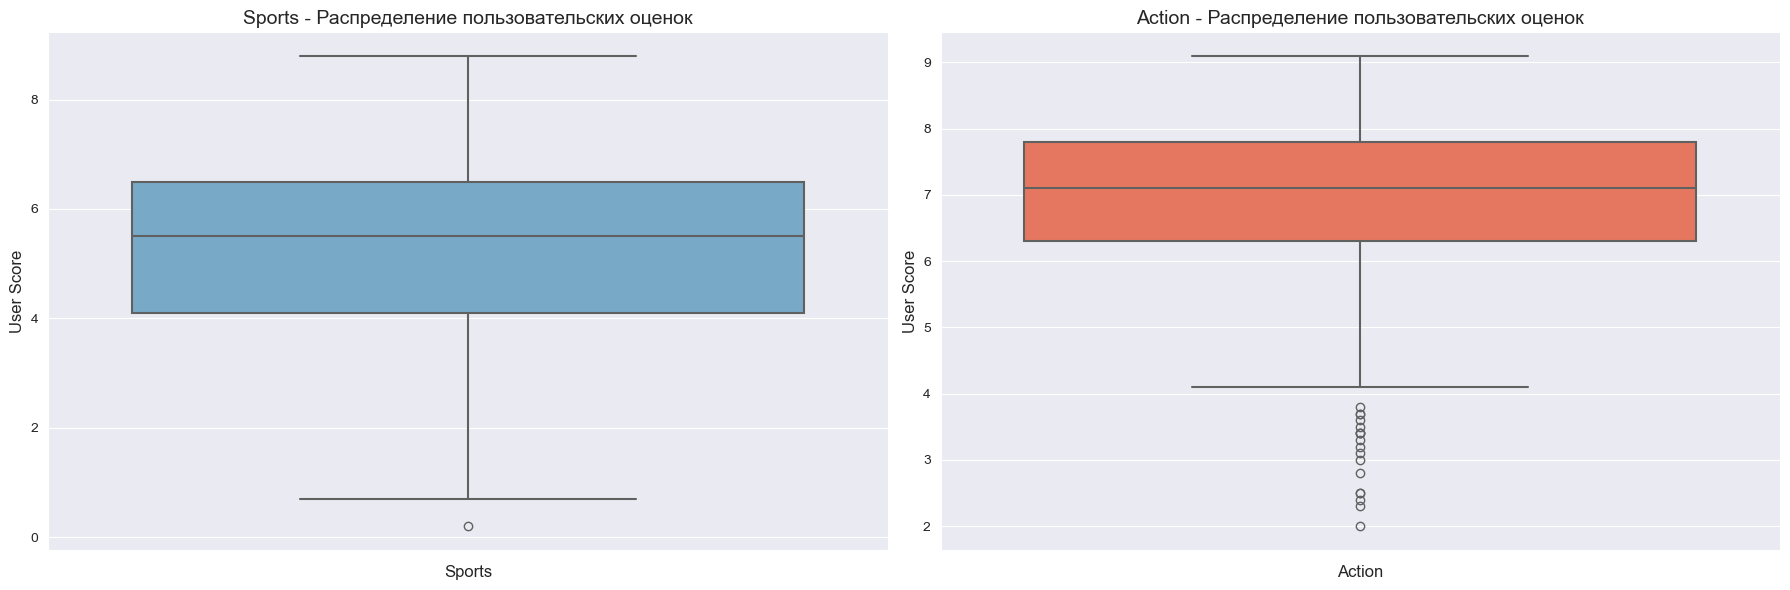

In [39]:
alpha = .05

action_scores = filtered_df.query('genre == "Sports"')['user_score'].dropna()
sports_scores = filtered_df.query('genre == "Action"')['user_score'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=action_scores, palette="Blues", showfliers=True, linewidth=1.5,
            ax=axes[0])
axes[0].set_title('Sports - Распределение пользовательских оценок', fontsize=14)
axes[0].set_xlabel('Sports', fontsize=12)
axes[0].set_ylabel('User Score', fontsize=12)

sns.boxplot(data=sports_scores, palette="Reds", showfliers=True, linewidth=1.5,
            ax=axes[1])
axes[1].set_title('Action - Распределение пользовательских оценок', fontsize=14)
axes[1].set_xlabel('Action', fontsize=12)
axes[1].set_ylabel('User Score', fontsize=12)

plt.tight_layout()
plt.show()

In [40]:
alpha = .05

action_scores = filtered_df.query('genre == "Sports"')['user_score'].dropna()
sports_scores = filtered_df.query('genre == "Action"')['user_score'].dropna()

res = st.ttest_ind(action_scores, sports_scores)

print("p-Value:", res.pvalue)

if res.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-Value: 1.0517772011408453e-27
Отвергаем нулевую гипотезу


**Промежуточный вывод:**
>_В ходе анализа данных был поставлен вопрос о равенстве средних пользовательских  
оценок для платформ XOne и PC. Для этого были сформированы две независимые  
генеральные совокупности: одна для пользователей PC, другая для пользователей XOne.  
Важно отметить, что данные совокупности независимы, так как пользователи  
могут использовать обе платформы, что следует учитывать при выборе метода  
тестирования.  
Для проверки гипотезы о равенстве средних двух совокупностей был выбран  
двусторонний t-тест, так как нужно сравнить два распределения без заранее  
установленного целевого значения.  
Нулевая гипотеза (H0) утверждает, что средние пользовательские рейтинги для  
платформ XOne и PC равны. Альтернативная гипотеза (H1) предполагает, что  
эти рейтинги различаются.  
По результатам теста не было оснований отвергать нулевую гипотезу, что  
означает, что средние пользовательские оценки платформ схожи и не было  
обнаружено статистически значимых различий. Это подтверждает предположение  
о схожести оценок между платформами.  
В ходе анализа также был поставлен вопрос о равенстве средних пользовательских  
оценок для жанров Action и Sports. Для этого были сформированы две  
независимые генеральные совокупности: одна для жанра Action, другая для жанра  
Sports.  
Важно учесть, что эти совокупности также независимы, так как пользователи могут  
играть в игры обоих жанров одновременно, что важно для выбора метода тестирования.  
Для проверки гипотезы о равенстве средних двух совокупностей был выбран  
двусторонний t-тест, так как требуется сравнить два распределения без заданного  
целевого значения.  
Нулевая гипотеза (H0) предполагает, что средние пользовательские рейтинги жанров  
Action и Sports схожи. Альтернативная гипотеза (H1) утверждает, что эти  
рейтинги различаются.  
Результаты теста показали, что при 5% уровне значимости есть основания для  
отвержения нулевой гипотезы, в пользу альтернативной._

# VI Шаг. Ход и итоги исследования

>_**Вывод по ШАГУ Ⅱ:**  
Пропуски в столбце 'name' оказались минимальными, их удаление не  
повлияет на результаты исследования. Это действие также решает проблему  
с пропусками в столбце 'genre'.  
Пропуски в столбце 'year_of_release' составляют лишь 1.6% от общего  
количества данных, что позволяет удалить поврежденные записи без  
существенных потерь.  
Для столбцов 'critic_score', 'user_score', 'rating' медианное значение  
не является наилучшим решением, так как качество релизов может  
сильно отличаться в зависимости от платформы.  
Данные подготовлены на высоком уровне. Пропуски в столбцах 'name'  
и 'genre' касаются одних и тех же строк и являются незначительными,  
скорее всего, случайными. Алгоритмы выгрузки и подготовки данных  
работают качественно.  
Пропуски в столбце 'year_of_release' можно отнести к случайным,  
их количество не указывает на проблемы в процессе сбора данных.  
Пропуски в столбцах 'critic_score', 'user_score', 'rating' имеют  
системный характер. Многие игры не имеют оценок от критиков или  
пользователей, а также не участвуют в программе Entertainment  
Software Rating Board, что объясняет отсутствие рейтинга._

  
>_**Вывод по ШАГУ Ⅲ:**  
С 1995 года наблюдается устойчивый рост количества выпускаемых  
игр. Пик пришелся на 2008-2009 годы, после чего наблюдается  
спад релизов.  
Лидерами по продажам за всё время стали PS2, X360, Wii, PS3, DS,  
PS.  
На пик популярности платформа выходит примерно за 4 года, после  
чего наступает спад выпускаемых игр. Примерный срок актуальности  
платформы — 7 лет.  
После 2014 года только PS4 и XOne демонстрируют рост продаж.  
3DS и PC остаются популярными и попадают в рекомендательный  
лист на 2017 год.  
Оценки критиков оказывают значительное влияние на объем продаж:  
чем выше оценка, тем больше копий продано.  
Лидерами продаж среди жанров стали Action и Shooter, что  
подтверждает правило "Спрос рождает предложение" — высокий  
спрос приводит к большому количеству выпускаемых игр и высоким  
средним продажам.  
Жанры спортивных симуляторов и Shooter также продемонстрировали  
высокие средние продажи, при этом Shooter продемонстрировал  
особое лидерство._

  
>_**Вывод по ШАГУ IV:**  
В Северной Америке и Европе пользователи активно покупают  
консольные издания, при этом PS4 является лидером продаж.  
Европейцы предпочитают PlayStation, на втором месте находится  
PS3, в то время как в Северной Америке PS3 отдали лишь 4-е место,  
а XBox One и XBox 360 заняли 2-е и 3-е место соответственно.  
В Японии пользователи предпочитают Nintendo 3DS, что связано  
с локальным производством этой консоли. 3DS также популярна в  
Европе и Северной Америке, но в Японии она занимает лидирующие  
позиции, а остальные места отданы местным консолям, включая PS4.  
Активные жанры игр, такие как Action и Shooter, популярны в  
Северной Америке и Европе, в Японии же фаворитом стал жанр RPG.  
Спортивные симуляторы заняли 3-е место по популярности в Европе  
и Северной Америке, но не вошли в топ-5 в Японии. В Японии же  
пользователи предпочитают fighting-игры, занявшие 4-е место в  
топе продаж.  
В Северной Америке и Европе большую часть игр с рейтингом M  
(взрослый контент) можно ожидать с высокими тиражами. В Японии  
пользователи предпочитают игры с рейтингом T (для подростков) или  
E (для всех), при этом многие игры не имеют актуального рейтинга._  


>_**Вывод по ШАГУ V:**  
При анализе данных был поставлен вопрос о равенстве средних  
пользовательских оценок для платформ XOne и PC. Для этого были  
сформированы две независимые генеральные совокупности.  
Так как пользователи могут использовать обе платформы, выбор  
метода тестирования требует учёта независимости данных.  
Для проверки гипотезы о равенстве средних был выбран двусторонний  
t-тест, поскольку необходимо сравнить два распределения без  
определённого целевого значения.  
Нулевая гипотеза (H0) утверждает, что средние пользовательские  
оценки для платформ XOne и PC равны, в то время как альтернативная  
гипотеза (H1) предполагает, что они различаются.  
Результаты теста не дали оснований отвергнуть нулевую гипотезу,  
что означает, что средние пользовательские рейтинги платформ XOne  
и PC схожи и не выявлены статистически значимые различия между  
ними.  
Аналогичный анализ был проведён для жанров Action и Sports,  
где были обнаружены статистически значимые различия между средними  
оценками. Для обоих тестов был установлен порог значимости в 5%._